In [1]:
# SARSA(λ), Q(λ), Dyna-Q

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def get_policy_metrics(env, pi, goal_state, optimal_Q, 
                       n_episodes=50, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    reached_goal, episode_reward, episode_regret = [], [], []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)
        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret
            
            state, reward, done, _ = env.step(action)
            episode_reward[-1] += reward
            
            steps += 1

        reached_goal.append(state == goal_state)
    results = np.array((np.sum(reached_goal)/len(reached_goal)*100, 
                        np.mean(episode_reward), 
                        np.mean(episode_regret)))
    return results

In [9]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [10]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    for i, state in enumerate(V_track.T):
        if V_true is not None and i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if V_true is not None:
            label = 'vπ({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

In [12]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

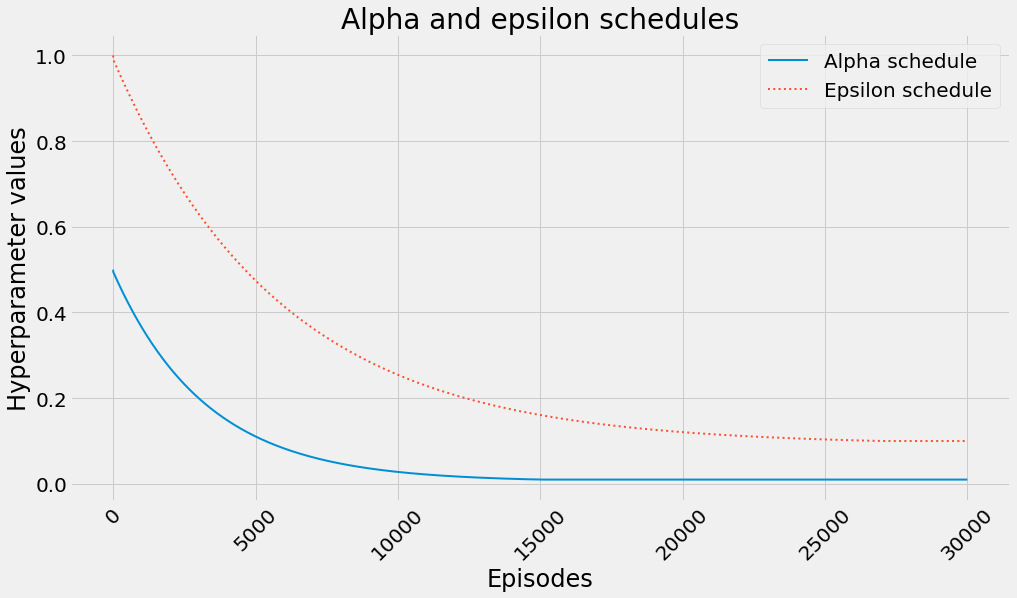

In [13]:
plt.plot([decay_schedule(0.5, 0.01, 0.5, 30000, i) for i in range(30000)], '-', linewidth=2, label='Alpha schedule')
plt.plot([decay_schedule(1.0, 0.1, 0.9, 30000, i) for i in range(30000)], ':', linewidth=2, label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()

In [14]:
env = gym.make('SlipperyWalkSeven-v0')
init_state = env.reset()
goal_state = 8
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=('<', '>'), n_cols=9)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤════════╤════════╕
│   s │      < │      > │
╞═════╪════════╪════════╡
│   0 │ 0      │ 0      │
├─────┼────────┼────────┤
│   1 │ 0.3119 │ 0.5637 │
├─────┼────────┼────────┤
│   2 │ 0.6703 │ 0.763  │
├─────┼────────┼────────┤
│   3 │ 0.8032 │ 0.8449 │
├─────┼────────┼────────┤
│   4 │ 0.8638 │ 0.8892 │
├─────┼────────┼────────┤
│   5 │ 0.9014 │ 0.922  │
├─────┼────────┼────────┤
│   6 │ 0.9322 │ 0.9515 │
├─────┼────────┼────────┤
│   7 │ 0.9613 │ 0.9806 │
├─────┼────────┼────────┤
│   8 │ 0      │ 0      │
╘═════╧════════╧════════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 96.00%. Obtains an average return of 0.9600. Regret of 0.0000


# SARSA(λ)

In [15]:
def sarsa_lambda(env,
                 gamma=1.0,
                 init_alpha=0.5,
                 min_alpha=0.01,
                 alpha_decay_ratio=0.5,
                 init_epsilon=1.0,
                 min_epsilon=0.1,
                 epsilon_decay_ratio=0.9,
                 lambda_=0.3,
                 n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))

    Q_track = np.zeros((n_episodes, nS, nA))
    E = np.zeros((nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e) 

        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)

            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            E[state][action] = E[state][action] + 1
            Q = Q + alpha * td_error * E
            E = gamma * lambda_ * E
            
            state, action = next_state, next_action

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [16]:
Q_sls, V_sls, Q_track_sls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env, gamma=0.99)
    Q_sls.append(Q_sl) ; V_sls.append(V_sl) ; Q_track_sls.append(Q_track_sl)
Q_sl, V_sl, Q_track_sl = np.mean(Q_sls, axis=0), np.mean(V_sls, axis=0), np.mean(Q_track_sls, axis=0)
del Q_sls ; del V_sls ; del Q_track_sls

In [17]:
print_state_value_function(V_sl, P, n_cols=9, prec=4, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', '>'), n_cols=9)
success_rate_sl, mean_return_sl, mean_regret_sl = get_policy_metrics(
    env, pi=pi_sl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sl, mean_return_sl, mean_regret_sl))

State-value function found by SARSA(λ):
|           | 01 0.4457 | 02  0.681 | 03  0.803 | 04   0.87 | 05 0.9085 | 06  0.945 | 07 0.9773 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.1181 | 02 -0.082 | 03 -0.0419 | 04 -0.0193 | 05 -0.0135 | 06 -0.0065 | 07 -0.0033 |           |
State-value function RMSE: 0.0506

SARSA(λ) action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.1761 │ 0.4457 │ 0.3119 │ 0.5637 │  0.1358 │  0.1181 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.4965 │ 0.681  │ 0.6703 │ 0.763  │  0.173

# Watkins' Q(λ)

In [18]:
def q_lambda(env,
             gamma=1.0,
             init_alpha=0.5,
             min_alpha=0.01,
             alpha_decay_ratio=0.5,
             init_epsilon=1.0,
             min_epsilon=0.1,
             epsilon_decay_ratio=0.9,
             lambda_=0.3,
             n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    E = np.zeros((nS, nA))

    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)
            
            next_greedy_action = np.argmax(Q[next_state])
            if Q[next_state][next_action] == Q[next_state][next_greedy_action]:
                next_greedy_action = next_action

            td_target = reward + gamma * Q[next_state][next_greedy_action] * (not done)
            td_error = td_target - Q[state][action]
            E[state][action] = np.clip(E[state][action] + 1, 0, 1)
            Q = Q + alpha * td_error * E
            if next_action == next_greedy_action:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [19]:
Q_qlls, V_qlls, Q_track_qlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99)
    Q_qlls.append(Q_qll) ; V_qlls.append(V_qll) ; Q_track_qlls.append(Q_track_qll)
Q_qll, V_qll, Q_track_qll = np.mean(Q_qlls, axis=0), np.mean(V_qlls, axis=0), np.mean(Q_track_qlls, axis=0)
del Q_qlls ; del V_qlls ; del Q_track_qlls

In [20]:
print_state_value_function(V_qll, P, n_cols=9, prec=4, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', '>'), n_cols=9)
success_rate_qll, mean_return_qll, mean_regret_qll = get_policy_metrics(
    env, pi=pi_qll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_qll, mean_return_qll, mean_regret_qll))

State-value function found by Q(λ):
|           | 01 0.5866 | 02 0.7653 | 03 0.8478 | 04 0.8925 | 05 0.9221 | 06 0.9518 | 07 0.9796 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 0.0228 | 02 0.0022 | 03 0.0029 | 04 0.0033 | 05 0.0001 | 06 0.0003 | 07 -0.001 |           |
State-value function RMSE: 0.0078

Q(λ) action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2885 │ 0.5866 │ 0.3119 │ 0.5637 │  0.0235 │ -0.0228 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6798 │ 0.7653 │ 0.6703 │ 0.763  │ -0.0095 │ -0.0022 │


# Dyna-Q

In [21]:
def dyna_q(env,
           gamma=1.0,
           init_alpha=0.5,
           min_alpha=0.01,
           alpha_decay_ratio=0.5,
           init_epsilon=1.0,
           min_epsilon=0.1,
           epsilon_decay_ratio=0.9,
           n_planning=3,             
           n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    T_count = np.zeros((nS, nA, nS))
    R_model = np.zeros((nS, nA, nS))

    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        alpha = decay_schedule(
            init_alpha, min_alpha, 
            alpha_decay_ratio, n_episodes, e)
        epsilon = decay_schedule(
            init_epsilon, min_epsilon, 
            epsilon_decay_ratio, n_episodes, e) 

        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error

            backup_next_state = next_state
            for _ in range(n_planning):
                if Q.sum() == 0: break

                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                reward = R_model[state][action][next_state]
                    
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alpha * td_error

            state = backup_next_state

        Q_track[e] = Q        
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [22]:
Q_dqs, V_dqs, Q_track_dqs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99)
    Q_dqs.append(Q_dq) ; V_dqs.append(V_dq) ; Q_track_dqs.append(Q_track_dq)
Q_dq, V_dq, Q_track_dq = np.mean(Q_dqs, axis=0), np.mean(V_dqs, axis=0), np.mean(Q_track_dqs, axis=0)
del Q_dqs ; del V_dqs ; del Q_track_dqs

In [23]:
print_state_value_function(V_dq, P, n_cols=9, prec=4, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', '>'), n_cols=9)
success_rate_dq, mean_return_dq, mean_regret_dq = get_policy_metrics(
    env, pi=pi_dq, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dq, mean_return_dq, mean_regret_dq))

State-value function found by Dyna-Q:
|           | 01 0.5582 | 02 0.7669 | 03 0.8497 | 04 0.8919 | 05 0.9253 | 06 0.9542 | 07 0.9813 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0056 | 02 0.0039 | 03 0.0048 | 04 0.0027 | 05 0.0033 | 06 0.0027 | 07 0.0007 |           |
State-value function RMSE: 0.0032

Dyna-Q action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2724 │ 0.5582 │ 0.3119 │ 0.5637 │  0.0395 │  0.0056 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6717 │ 0.7669 │ 0.6703 │ 0.763  │ -0.0014 │ -0.00

# Comparison of max(Q) for every episode

## SARSA(λ)

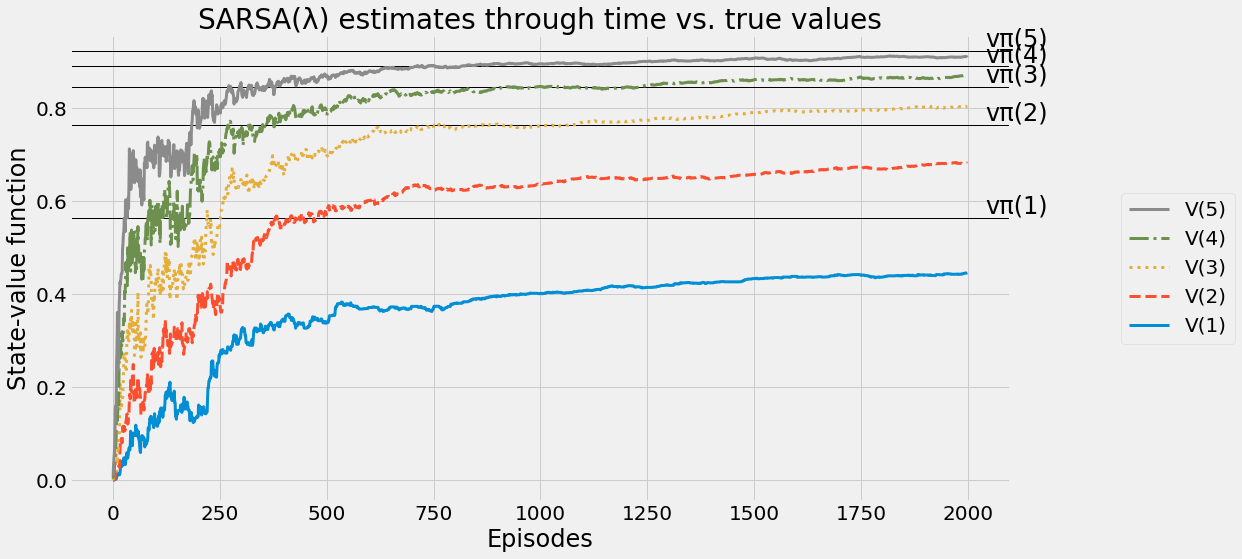

In [24]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

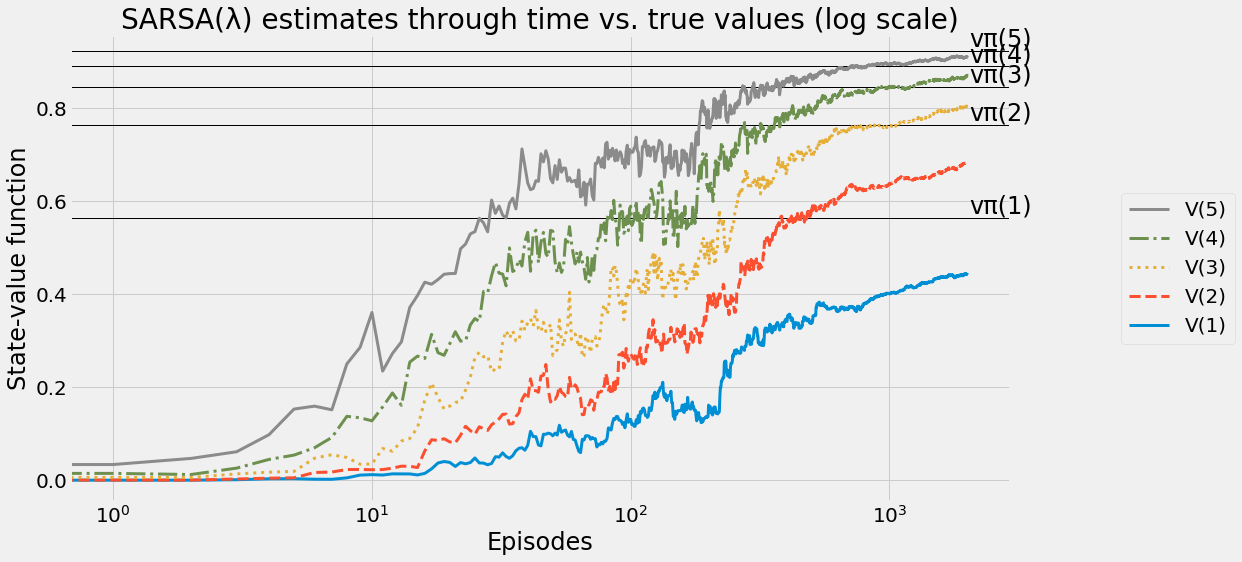

In [25]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

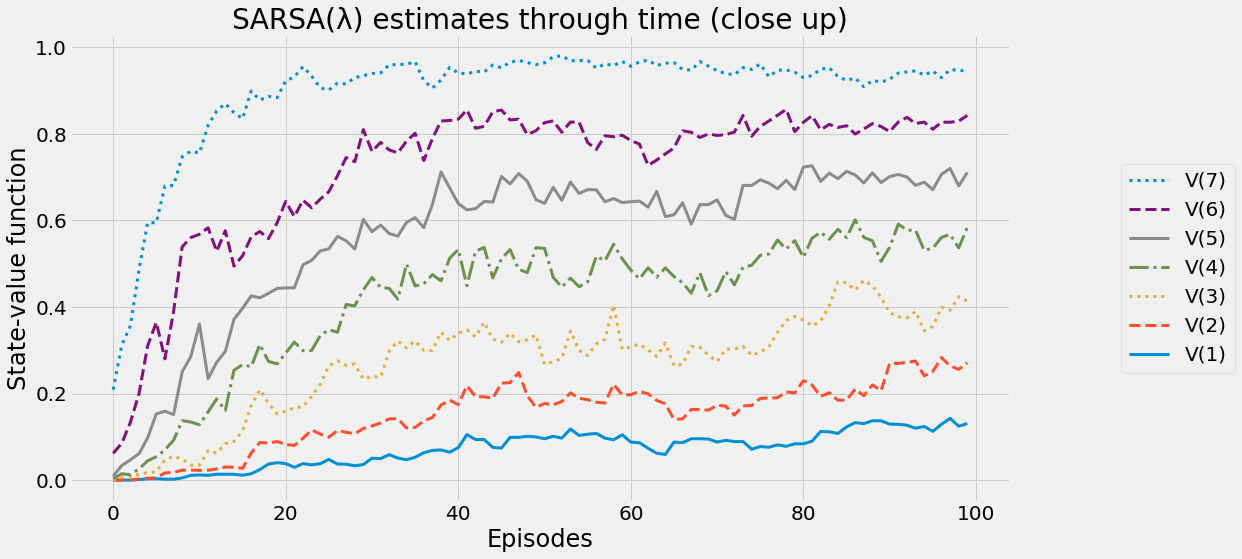

In [26]:
plot_value_function(
    'SARSA(λ) estimates through time (close up)', 
    np.max(Q_track_sl, axis=2)[:100], 
    None,
    log=False)

## Q(λ)

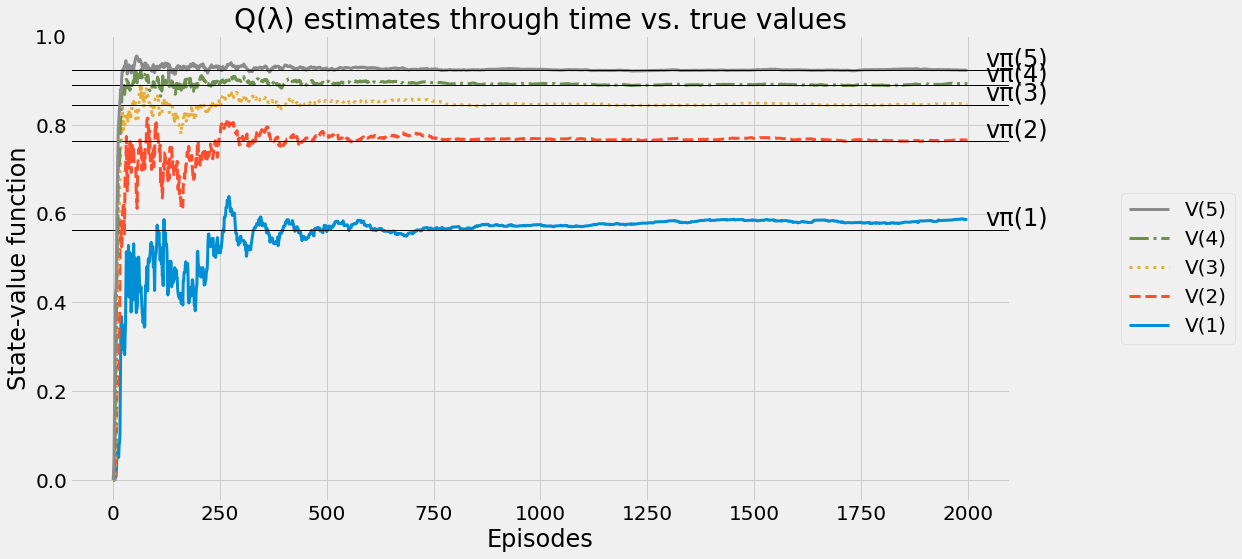

In [27]:
plot_value_function(
    'Q(λ) estimates through time vs. true values', 
    np.max(Q_track_qll, axis=2), 
    optimal_V,
    limit_items=5,
    log=False)

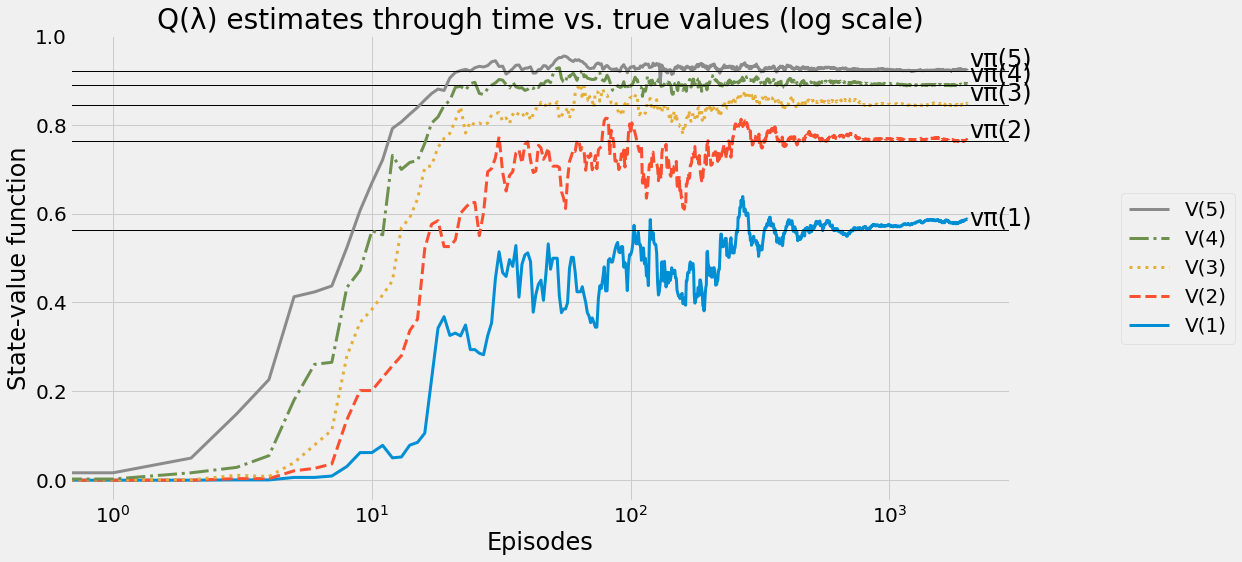

In [28]:
plot_value_function(
    'Q(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_qll, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

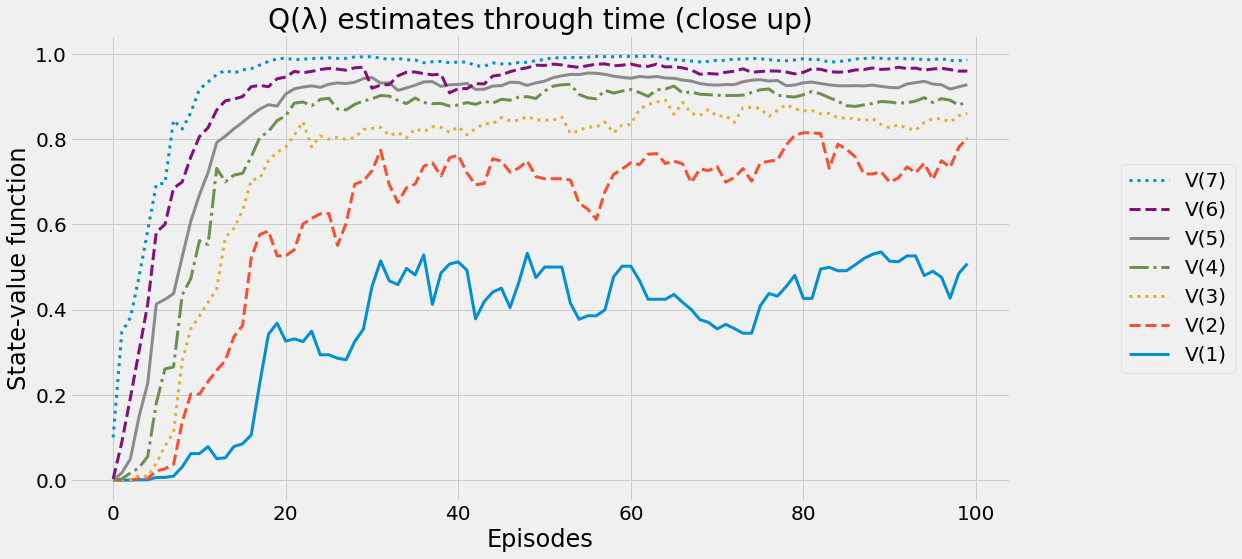

In [29]:
plot_value_function(
    'Q(λ) estimates through time (close up)', 
    np.max(Q_track_qll, axis=2)[:100], 
    None,
    log=False)

## Dyna-Q

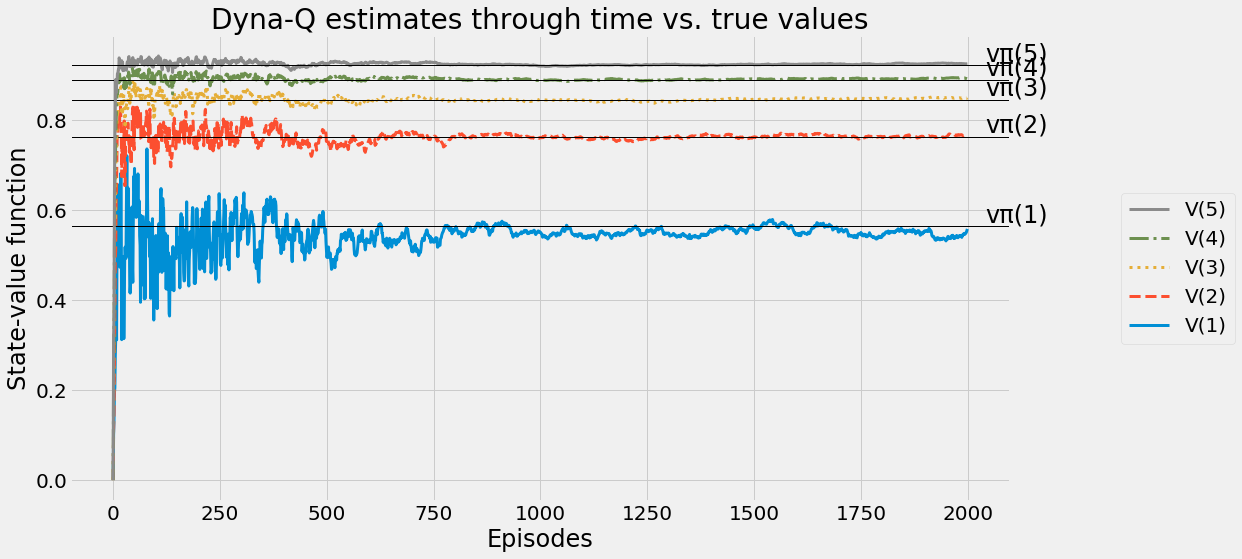

In [30]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

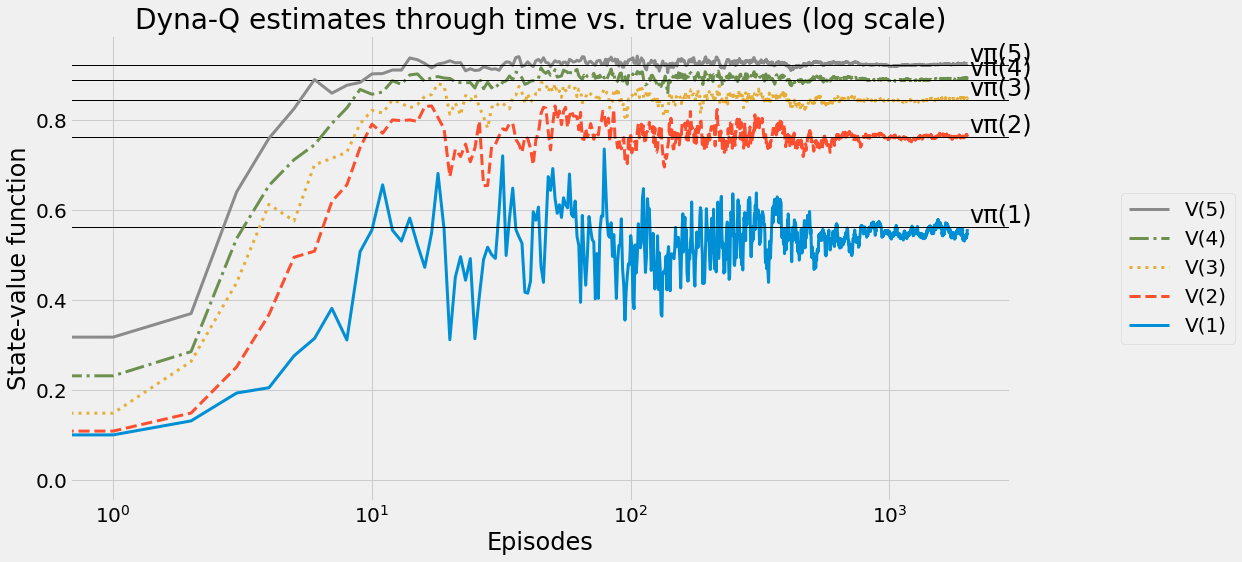

In [31]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (log scale)', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

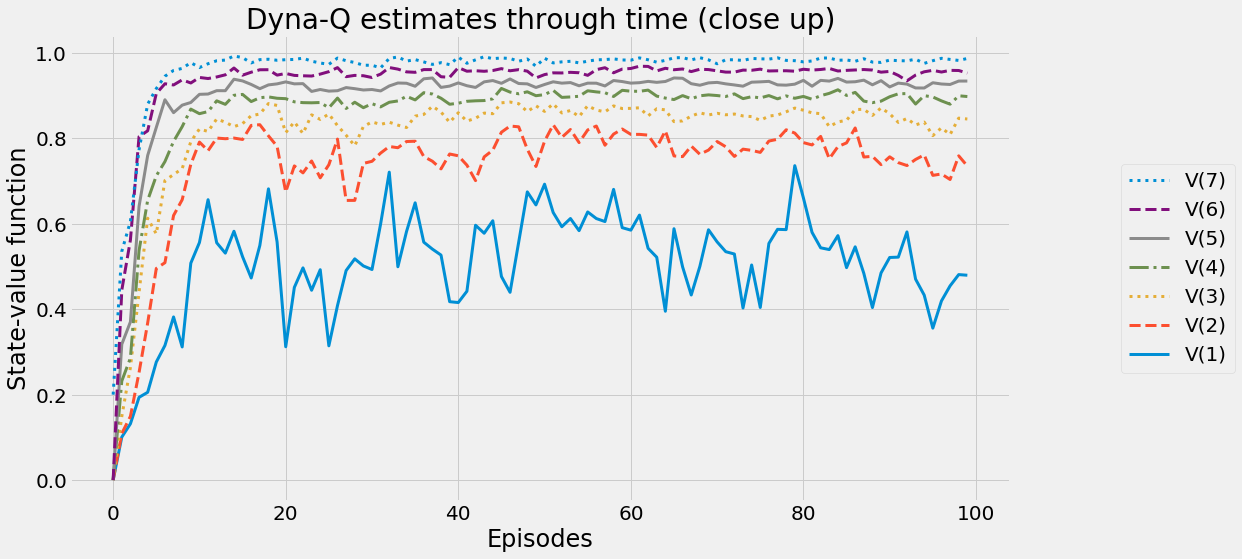

In [32]:
plot_value_function(
    'Dyna-Q estimates through time (close up)', 
    np.max(Q_track_dq, axis=2)[:100], 
    None,
    log=False)

# Policy evolution comparison

In [33]:
sl_success_rate_ma, sl_mean_return_ma, sl_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_sl)])).T

In [34]:
qll_success_rate_ma, qll_mean_return_ma, qll_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_qll)])).T

In [35]:
dq_success_rate_ma, dq_mean_return_ma, dq_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_dq)])).T

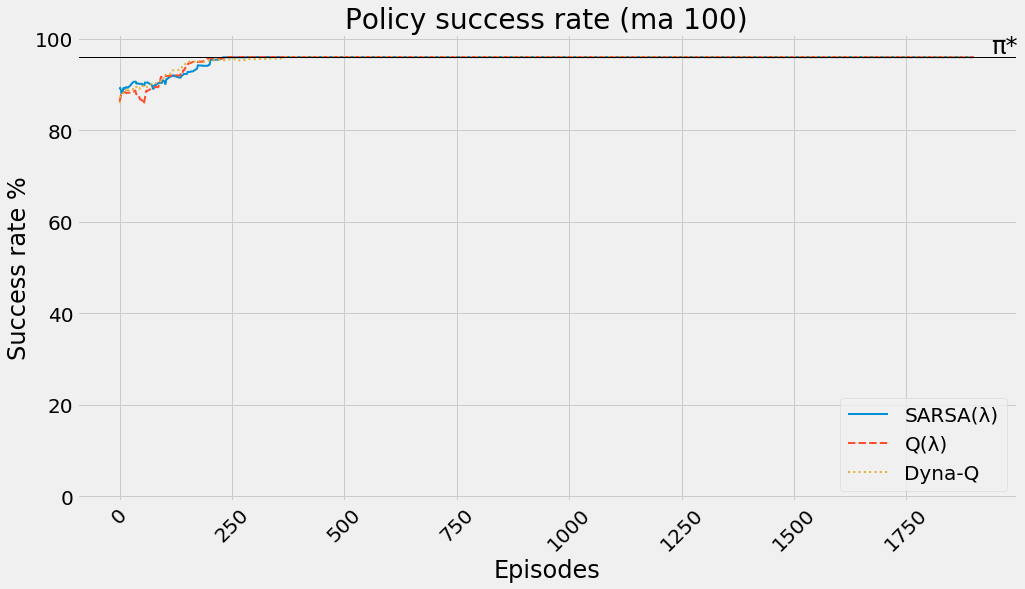

In [36]:
plt.plot(sl_success_rate_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_success_rate_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_success_rate_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(sl_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

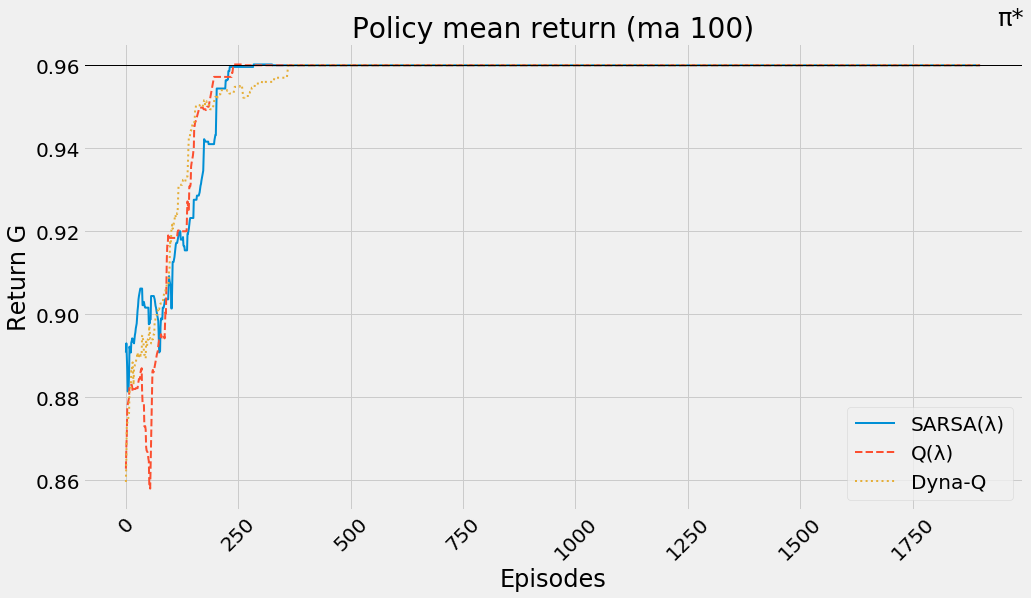

In [37]:
plt.plot(sl_mean_return_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_mean_return_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_mean_return_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(sl_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.title('Policy mean return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return G')

plt.xticks(rotation=45)

plt.show()

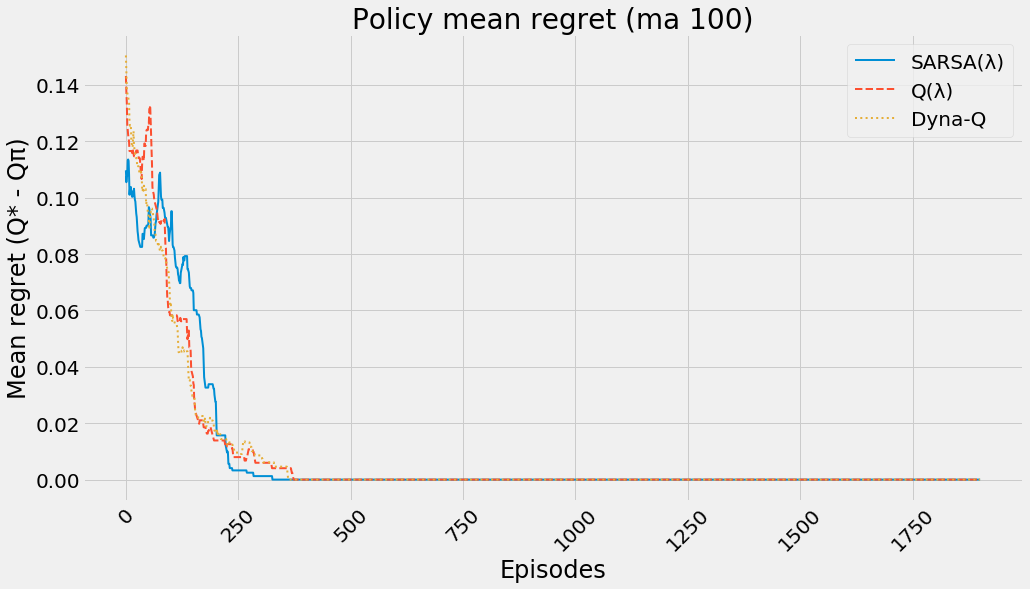

In [38]:
plt.plot(sl_mean_regret_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_mean_regret_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_mean_regret_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Policy mean regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

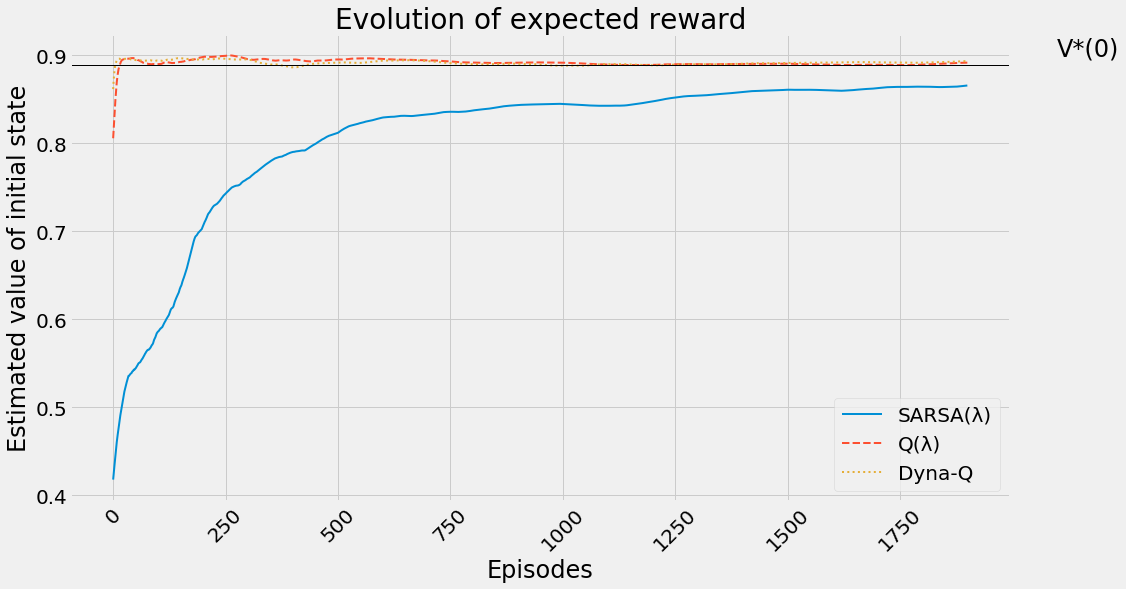

In [39]:
plt.plot(moving_average(np.max(Q_track_sl, axis=2).T[init_state]), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.max(Q_track_qll, axis=2).T[init_state]), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[init_state]), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_sl)*1.05), optimal_V[init_state]+.01, 'V*(0)')

plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

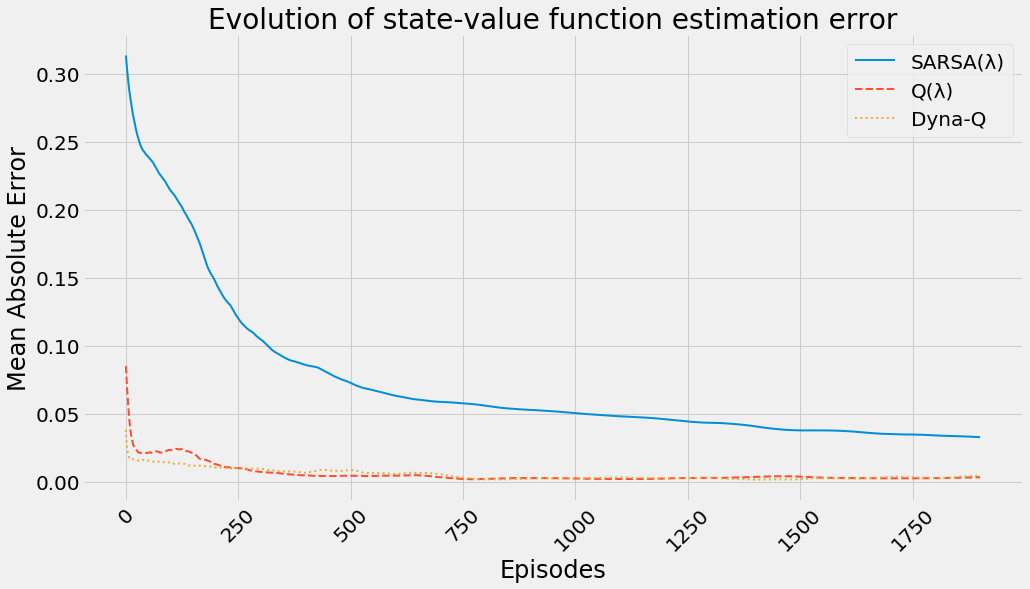

In [40]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sl, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_qll, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

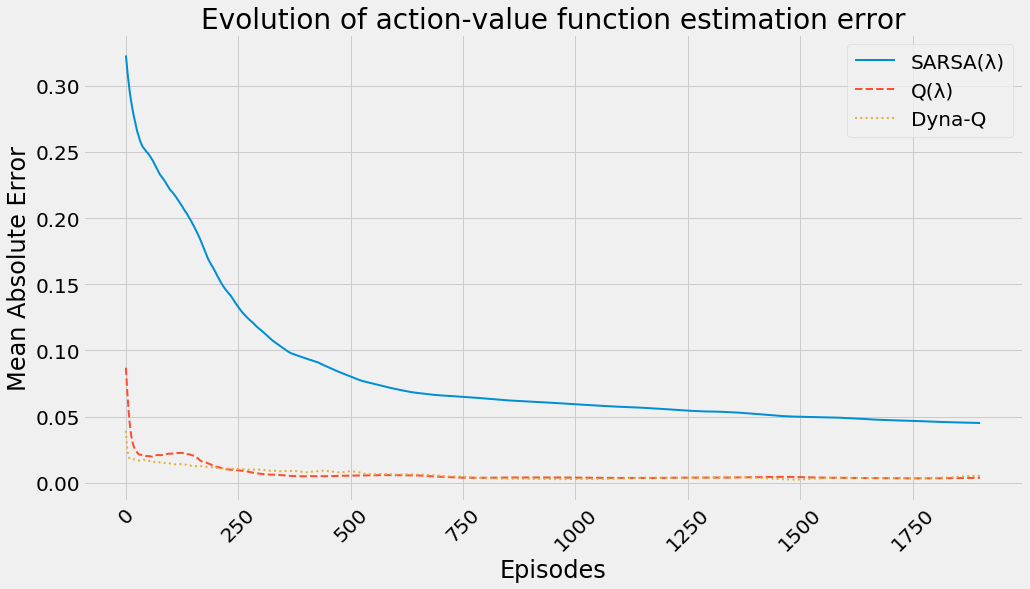

In [41]:
plt.plot(moving_average(np.mean(np.abs(Q_track_sl - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_qll - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

# FrozenLake environment

In [42]:
env = gym.make('FrozenLake-v0')
init_state = env.reset()
goal_state = 15
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │
╞═════╪════════╪════════╪════════╪════════╡
│   0 │ 0.542  │ 0.5278 │ 0.5278 │ 0.5223 │
├─────┼────────┼────────┼────────┼────────┤
│   1 │ 0.3435 │ 0.3342 │ 0.3199 │ 0.4988 │
├─────┼────────┼────────┼────────┼────────┤
│   2 │ 0.4382 │ 0.4336 │ 0.4243 │ 0.4707 │
├─────┼────────┼────────┼────────┼────────┤
│   3 │ 0.3061 │ 0.3061 │ 0.3015 │ 0.4569 │
├─────┼────────┼────────┼────────┼────────┤
│   4 │ 0.5585 │ 0.3796 │ 0.3742 │ 0.3632 │
├─────┼────────┼────────┼────────┼────────┤
│   5 │ 0      │ 0      │ 0      │ 0      │
├─────┼────────┼────────┼────────┼────────┤
│   6 │ 0.3583 │ 0.203  │ 0.3583 │ 0.1553 │
├─────┼────────┼────────┼────────┼

In [43]:
Q_sls, V_sls, Q_track_sls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env, gamma=0.99, n_episodes=10000)
    Q_sls.append(Q_sl) ; V_sls.append(V_sl) ; Q_track_sls.append(Q_track_sl)
Q_sl, V_sl, Q_track_sl = np.mean(Q_sls, axis=0), np.mean(V_sls, axis=0), np.mean(Q_track_sls, axis=0)
del Q_sls ; del V_sls ; del Q_track_sls

In [44]:
print_state_value_function(V_sl, P, n_cols=4, prec=3, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_sl, mean_return_sl, mean_regret_sl = get_policy_metrics(
    env, pi=pi_sl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sl, mean_return_sl, mean_regret_sl))

State-value function found by SARSA(λ):
| 00   0.29 | 01  0.239 | 02  0.206 | 03  0.137 |
| 04  0.308 |           | 06  0.201 |           |
| 08  0.354 | 09  0.445 | 10  0.458 |           |
|           | 13  0.582 | 14  0.773 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.252 | 01  -0.26 | 02 -0.265 | 03  -0.32 |
| 04 -0.251 |           | 06 -0.157 |           |
| 08 -0.238 | 09 -0.199 | 10 -0.157 |           |
|           | 13  -0.16 | 14  -0.09 |           |
State-value function RMSE: 0.1847

SARSA(λ) action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪════

In [45]:
Q_qlls, V_qlls, Q_track_qlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99, n_episodes=10000)
    Q_qlls.append(Q_qll) ; V_qlls.append(V_qll) ; Q_track_qlls.append(Q_track_qll)
Q_qll, V_qll, Q_track_qll = np.mean(Q_qlls, axis=0), np.mean(V_qlls, axis=0), np.mean(Q_track_qlls, axis=0)
del Q_qlls ; del V_qlls ; del Q_track_qlls

In [46]:
print_state_value_function(V_qll, P, n_cols=4, prec=3, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_qll, mean_return_qll, mean_regret_qll = get_policy_metrics(
    env, pi=pi_qll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_qll, mean_return_qll, mean_regret_qll))

State-value function found by Q(λ):
| 00  0.521 | 01  0.474 | 02  0.444 | 03  0.429 |
| 04  0.541 |           | 06  0.345 |           |
| 08  0.575 | 09  0.628 | 10  0.607 |           |
|           | 13  0.732 | 14  0.856 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.021 | 01 -0.025 | 02 -0.026 | 03 -0.027 |
| 04 -0.017 |           | 06 -0.013 |           |
| 08 -0.016 | 09 -0.015 | 10 -0.008 |           |
|           | 13  -0.01 | 14 -0.007 |           |
State-value function RMSE: 0.0152

Q(λ) action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═════

In [47]:
Q_dqs, V_dqs, Q_track_dqs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99, n_episodes=10000)
    Q_dqs.append(Q_dq) ; V_dqs.append(V_dq) ; Q_track_dqs.append(Q_track_dq)
Q_dq, V_dq, Q_track_dq = np.mean(Q_dqs, axis=0), np.mean(V_dqs, axis=0), np.mean(Q_track_dqs, axis=0)
del Q_dqs ; del V_dqs ; del Q_track_dqs

In [48]:
print_state_value_function(V_dq, P, n_cols=4, prec=3, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
success_rate_dq, mean_return_dq, mean_regret_dq = get_policy_metrics(
    env, pi=pi_dq, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dq, mean_return_dq, mean_regret_dq))

State-value function found by Dyna-Q:
| 00  0.528 | 01  0.487 | 02  0.458 | 03  0.447 |
| 04  0.546 |           | 06  0.352 |           |
| 08   0.58 | 09  0.626 | 10  0.596 |           |
|           | 13  0.726 | 14  0.854 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.014 | 01 -0.011 | 02 -0.013 | 03  -0.01 |
| 04 -0.012 |           | 06 -0.006 |           |
| 08 -0.012 | 09 -0.017 | 10 -0.019 |           |
|           | 13 -0.015 | 14 -0.009 |           |
State-value function RMSE: 0.0108

Dyna-Q action-value function:
╒═════╤══════╤══════╤══════╤══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │    < │    v │    > │    ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪══════╪══════╪═

# Comparison of max(Q) for every episode

## SARSA(λ)

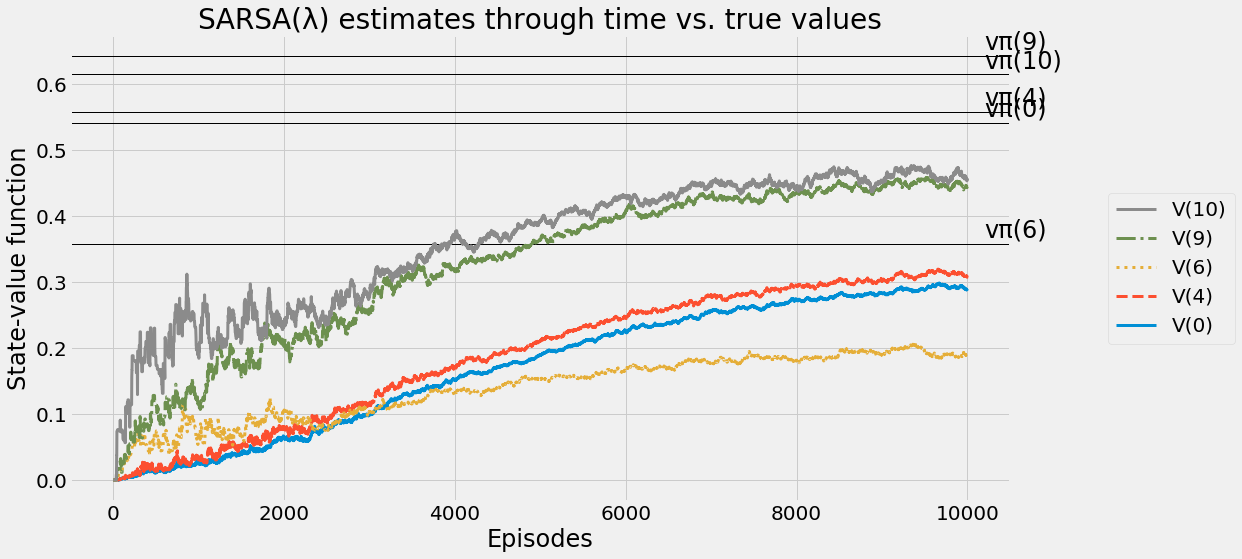

In [49]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

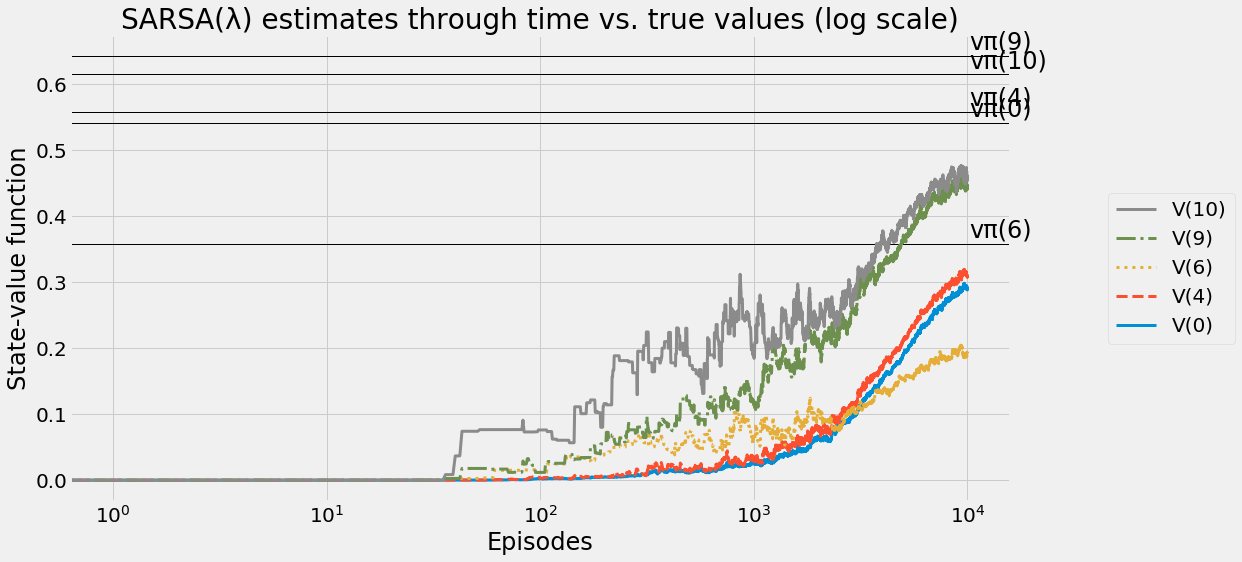

In [50]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

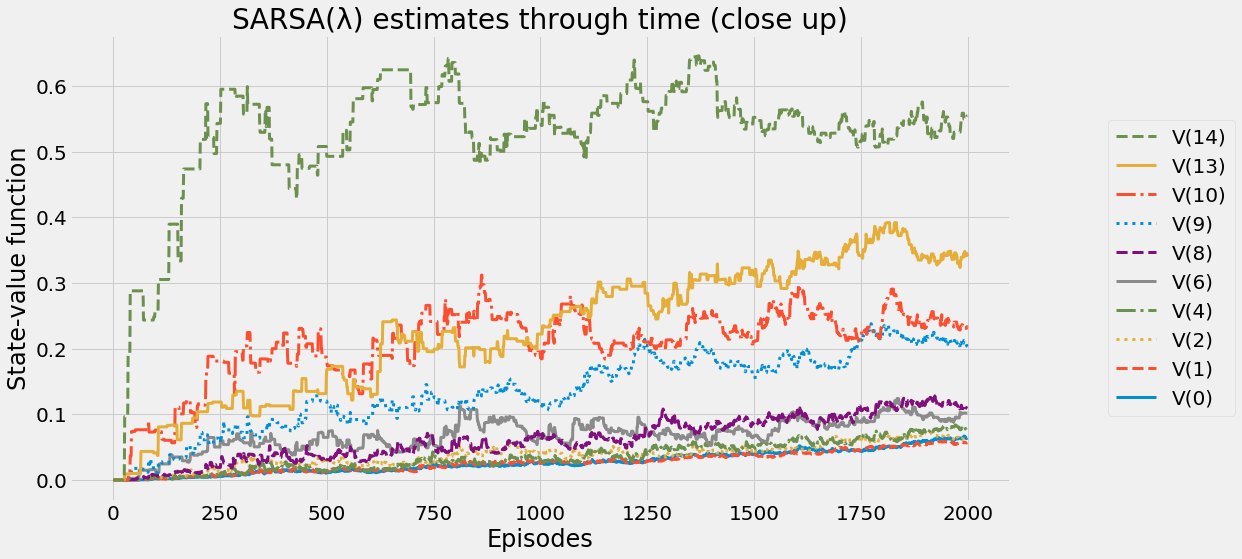

In [51]:
plot_value_function(
    'SARSA(λ) estimates through time (close up)', 
    np.max(Q_track_sl, axis=2)[:2000], 
    None,
    log=False)

## Q(λ)

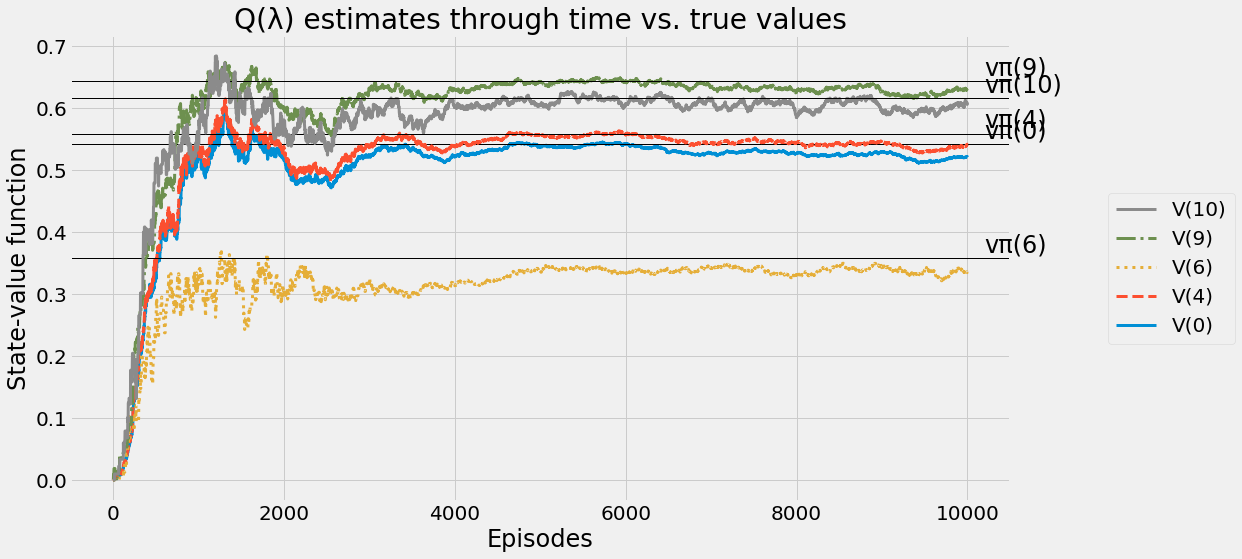

In [52]:
plot_value_function(
    'Q(λ) estimates through time vs. true values', 
    np.max(Q_track_qll, axis=2), 
    optimal_V,
    limit_items=5,
    log=False)

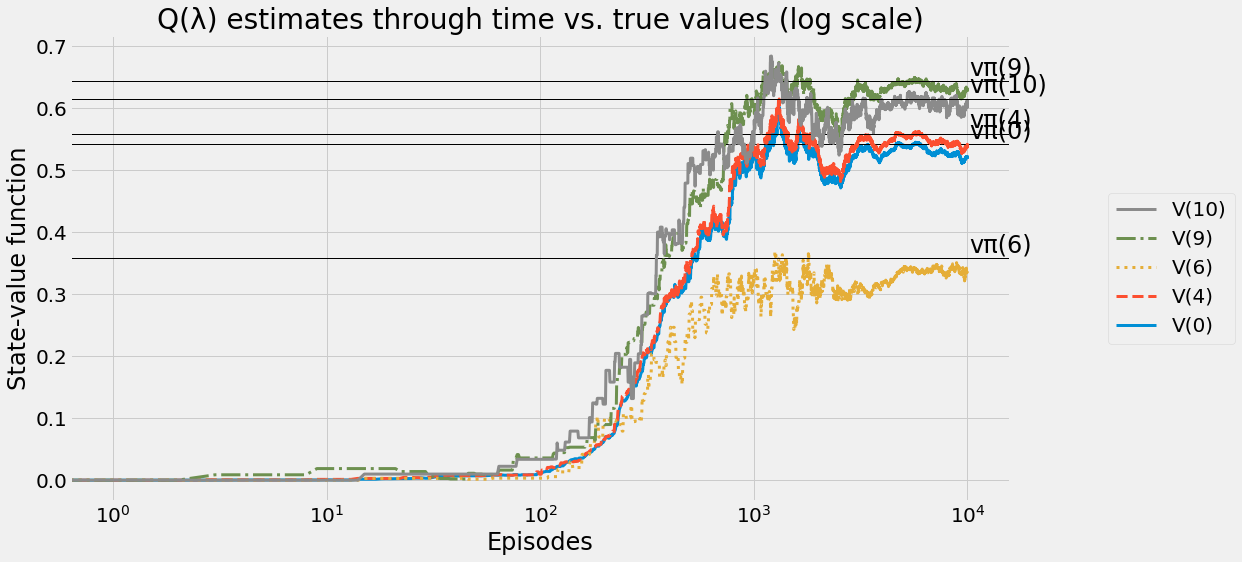

In [53]:
plot_value_function(
    'Q(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_qll, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

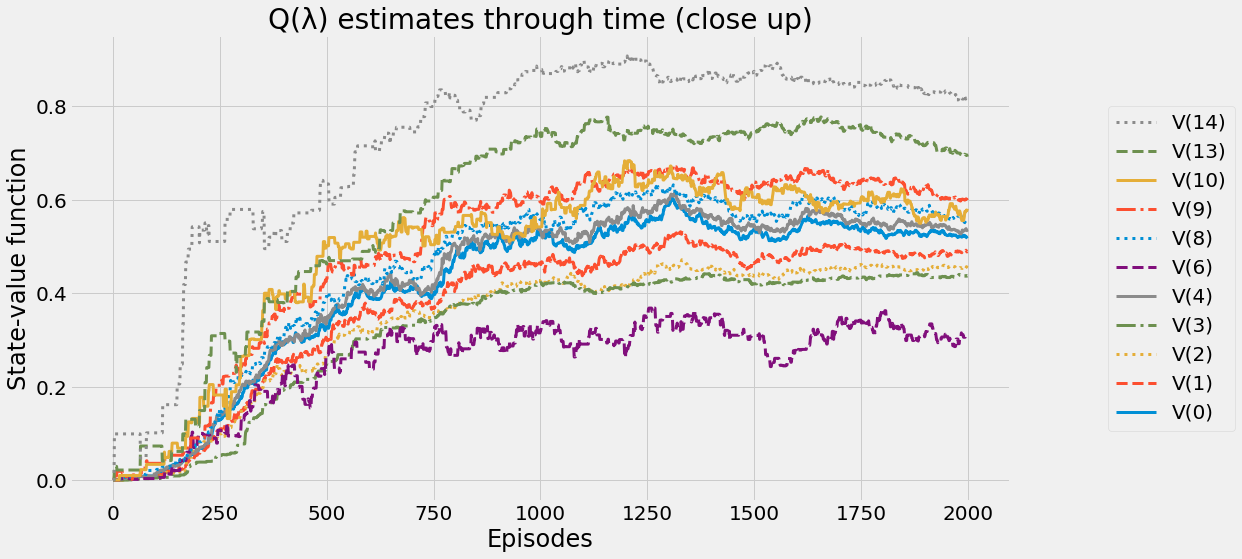

In [54]:
plot_value_function(
    'Q(λ) estimates through time (close up)', 
    np.max(Q_track_qll, axis=2)[:2000], 
    None,
    log=False)

## Dyna-Q

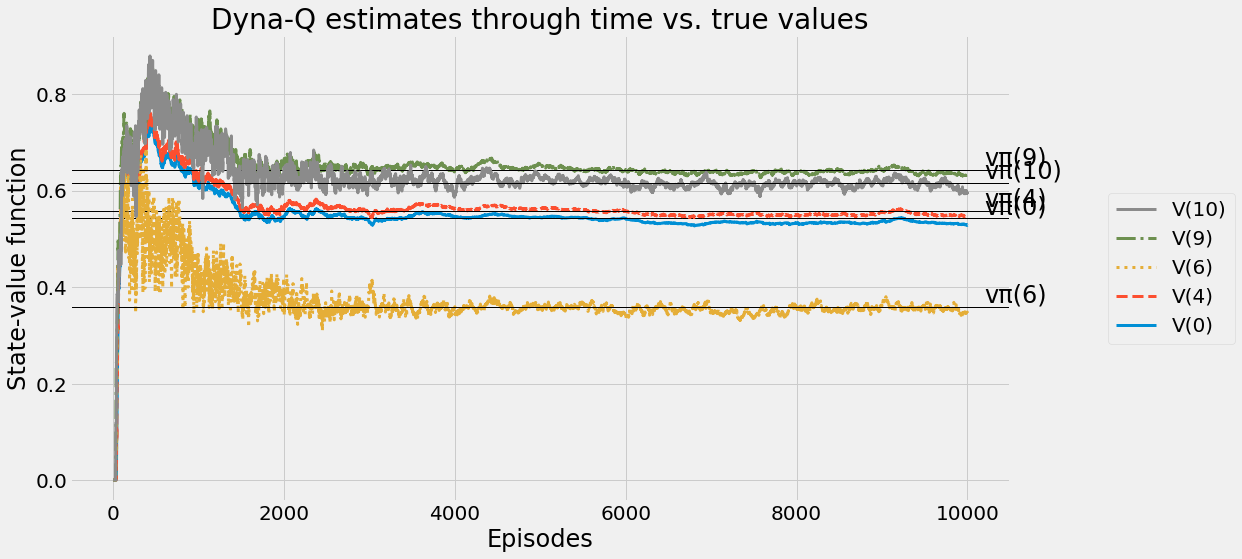

In [55]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=5,
    log=False)

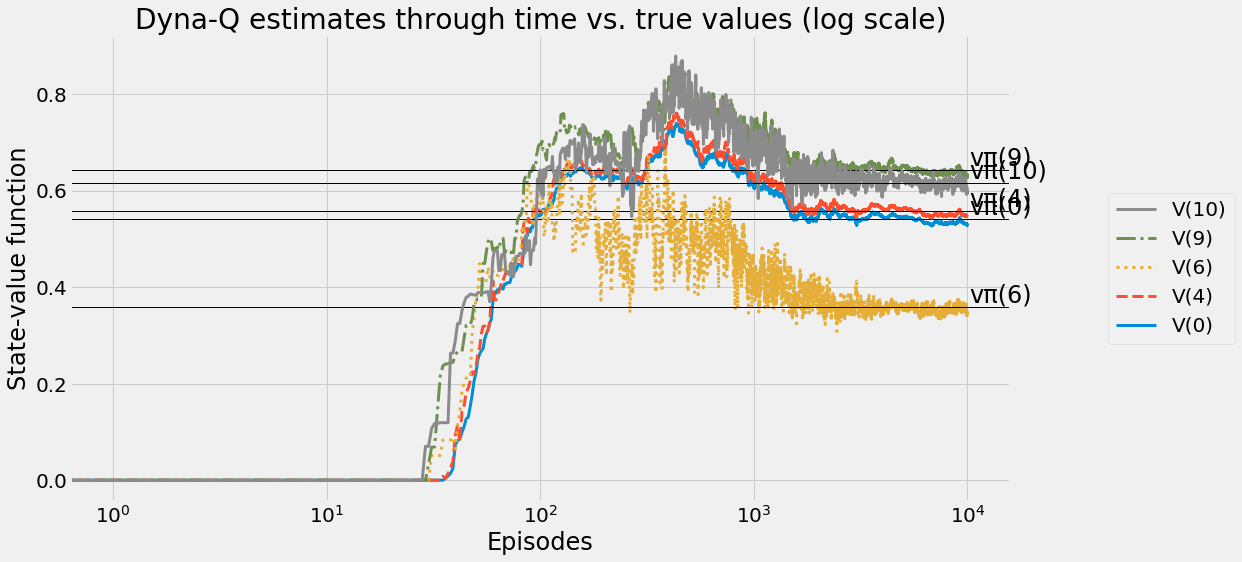

In [56]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (log scale)', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=5,
    log=True)

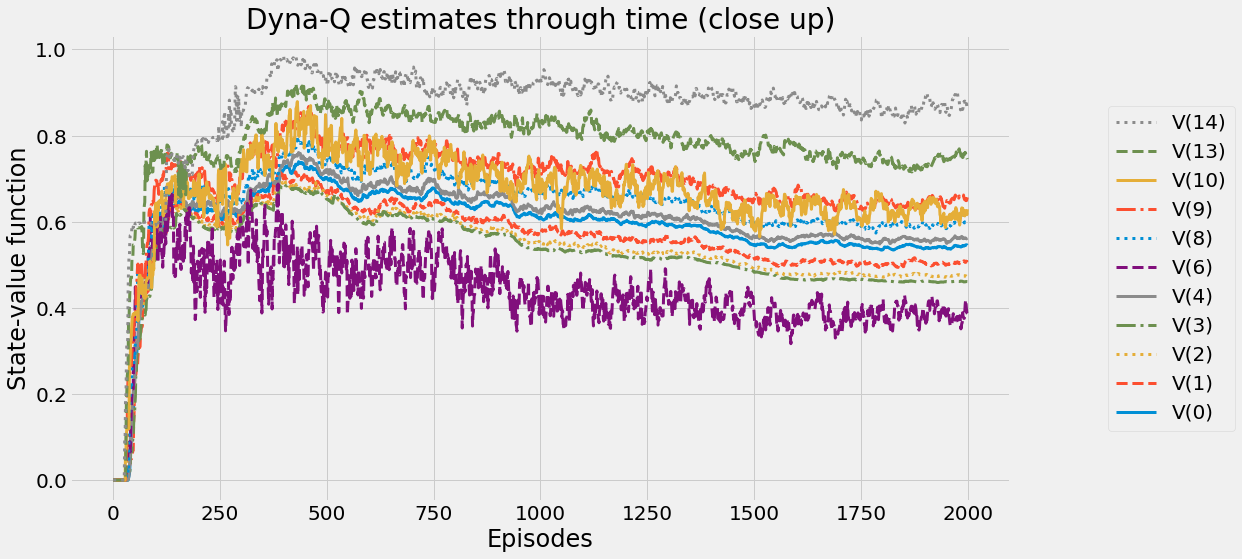

In [57]:
plot_value_function(
    'Dyna-Q estimates through time (close up)', 
    np.max(Q_track_dq, axis=2)[:2000], 
    None,
    log=False)

# Policy evolution comparison

In [58]:
sl_success_rate_ma, sl_mean_return_ma, sl_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_sl)])).T

In [59]:
qll_success_rate_ma, qll_mean_return_ma, qll_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_qll)])).T

In [60]:
dq_success_rate_ma, dq_mean_return_ma, dq_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_dq)])).T

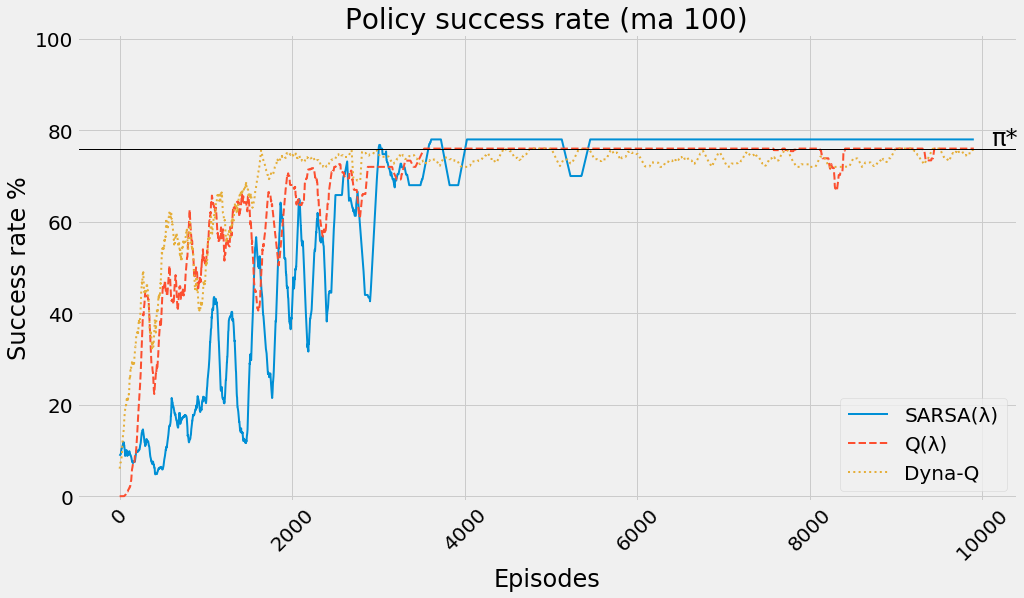

In [61]:
plt.plot(sl_success_rate_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_success_rate_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_success_rate_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(sl_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

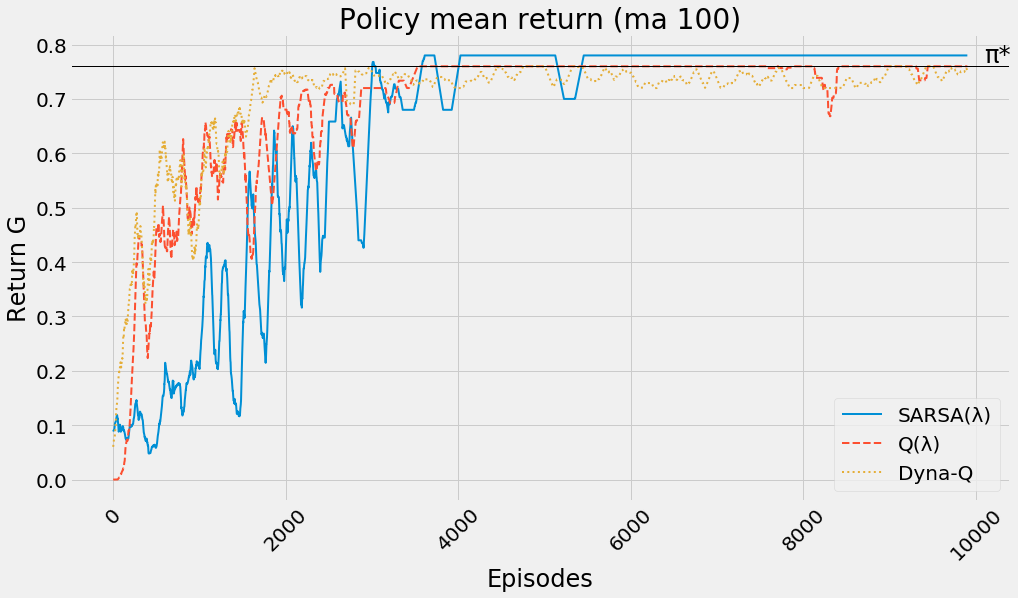

In [62]:
plt.plot(sl_mean_return_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_mean_return_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_mean_return_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(sl_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.title('Policy mean return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return G')

plt.xticks(rotation=45)

plt.show()

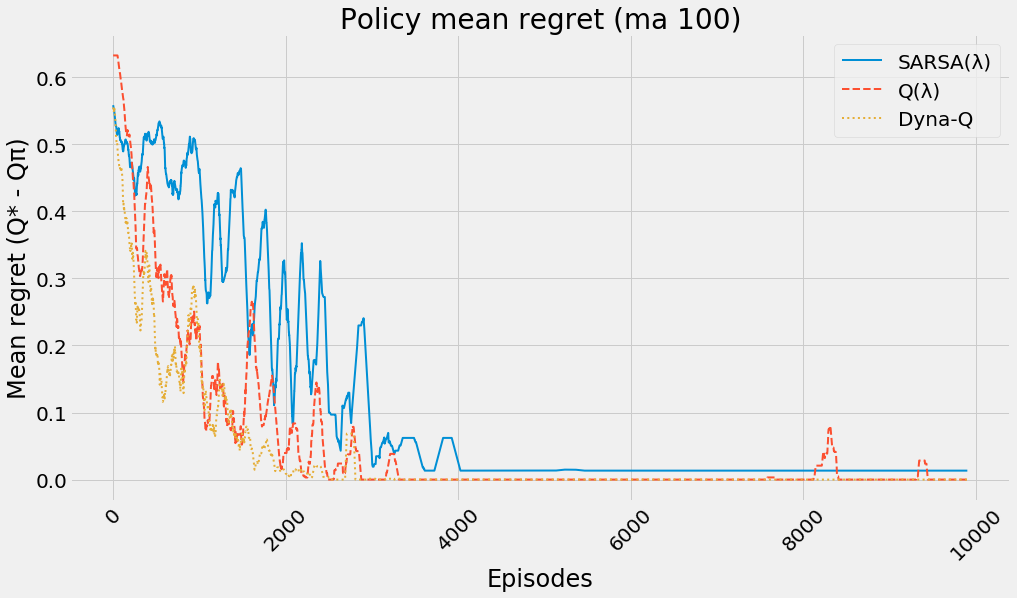

In [63]:
plt.plot(sl_mean_regret_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_mean_regret_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_mean_regret_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Policy mean regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

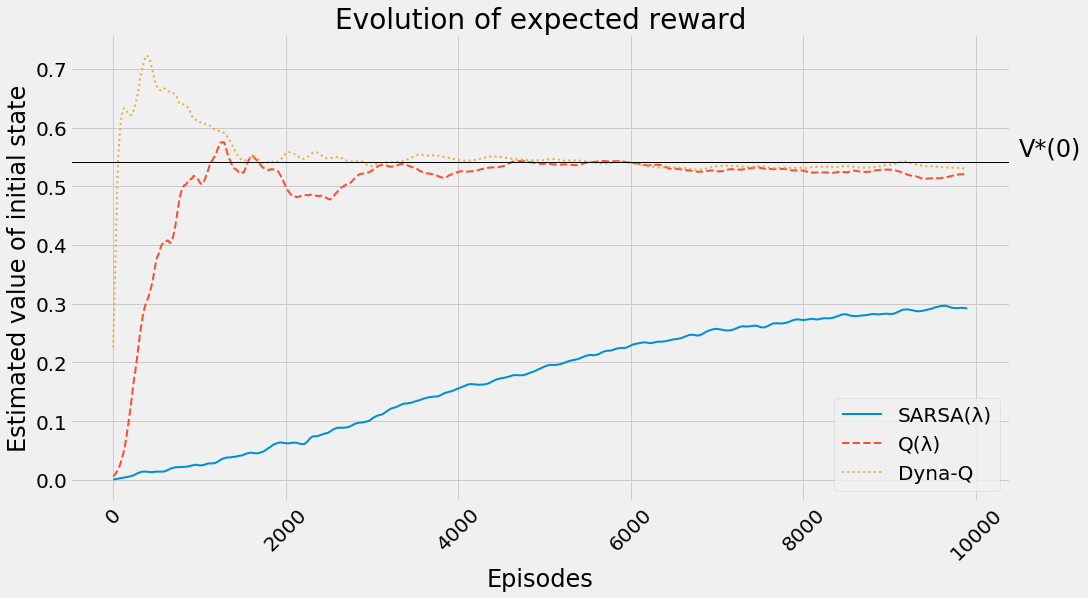

In [64]:
plt.plot(moving_average(np.max(Q_track_sl, axis=2).T[init_state]), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.max(Q_track_qll, axis=2).T[init_state]), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[init_state]), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_sl)*1.05), optimal_V[init_state]+.01, 'V*(0)')

plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

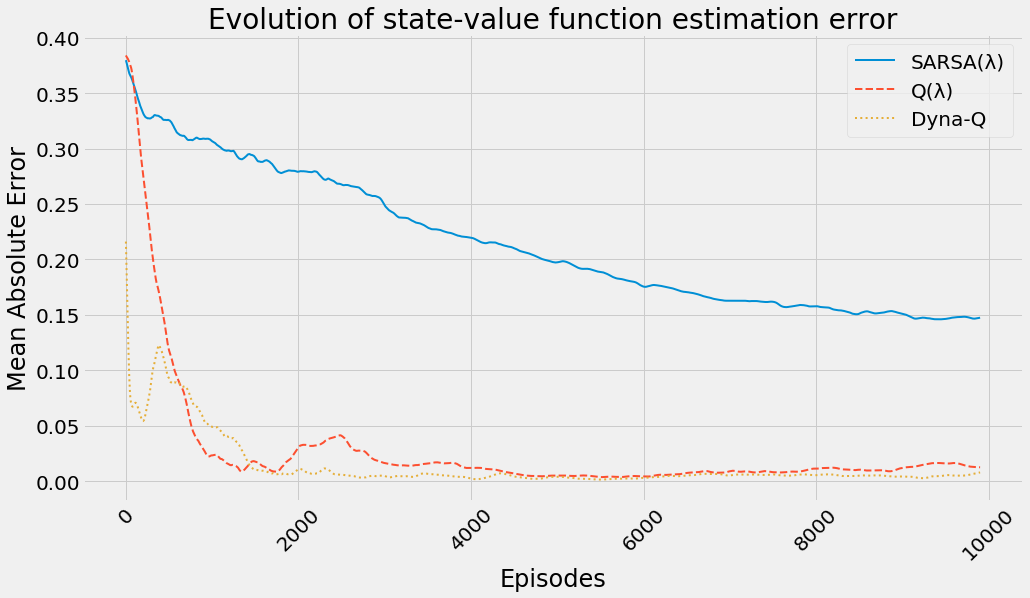

In [65]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sl, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_qll, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

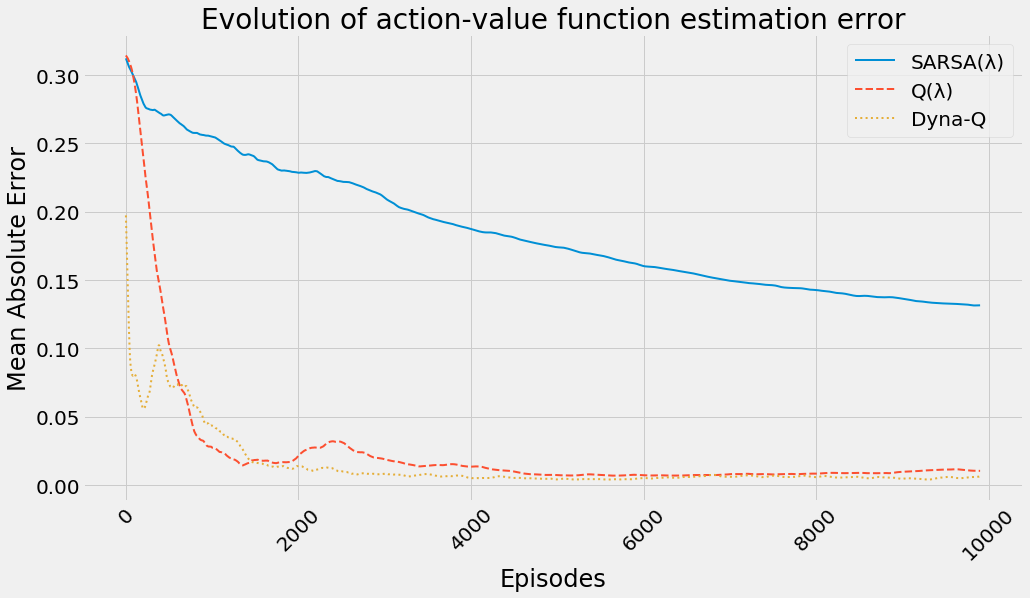

In [66]:
plt.plot(moving_average(np.mean(np.abs(Q_track_sl - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_qll - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

# FrozenLake XL (8x8)

In [67]:
env = gym.make('FrozenLake8x8-v0')
init_state = env.reset()
goal_state = 63
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=8, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()
print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_op, mean_return_op, mean_regret_op))

Optimal state-value function:
| 00 0.4146 | 01 0.4272 | 02 0.4461 | 03 0.4683 | 04 0.4924 | 05 0.5166 | 06 0.5353 | 07  0.541 |
| 08 0.4117 | 09 0.4212 | 10 0.4375 | 11 0.4584 | 12 0.4832 | 13 0.5135 | 14 0.5458 | 15 0.5574 |
| 16 0.3968 | 17 0.3938 | 18 0.3755 |           | 20 0.4217 | 21 0.4938 | 22 0.5612 | 23 0.5859 |
| 24 0.3693 | 25  0.353 | 26 0.3065 | 27 0.2004 | 28 0.3008 |           | 30  0.569 | 31 0.6283 |
| 32 0.3327 | 33 0.2914 | 34 0.1973 |           | 36 0.2893 | 37  0.362 | 38 0.5348 | 39 0.6897 |
| 40 0.3061 |           |           | 43 0.0863 | 44 0.2139 | 45 0.2727 |           | 47  0.772 |
| 48 0.2889 |           | 50 0.0577 | 51 0.0475 |           | 53 0.2505 |           | 55 0.8778 |
| 56 0.2804 | 57 0.2008 | 58 0.1273 |           | 60 0.2396 | 61 0.4864 | 62 0.7371 |           |

Optimal action-value function:
╒═════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │
╞═════╪════════╪════════╪════════╪════════╡
│   0 │ 0.4095 │ 0.413

In [68]:
Q_sls, V_sls, Q_track_sls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env, gamma=0.99, n_episodes=25000)
    Q_sls.append(Q_sl) ; V_sls.append(V_sl) ; Q_track_sls.append(Q_track_sl)
Q_sl, V_sl, Q_track_sl = np.mean(Q_sls, axis=0), np.mean(V_sls, axis=0), np.mean(Q_track_sls, axis=0)
del Q_sls ; del V_sls ; del Q_track_sls

In [69]:
print_state_value_function(V_sl, P, n_cols=8, prec=2, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=8, prec=2, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=8, prec=2, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
success_rate_sl, mean_return_sl, mean_regret_sl = get_policy_metrics(
    env, pi=pi_sl, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sl, mean_return_sl, mean_regret_sl))

State-value function found by SARSA(λ):
| 00   0.18 | 01   0.19 | 02   0.21 | 03   0.22 | 04   0.24 | 05   0.26 | 06   0.28 | 07   0.28 |
| 08   0.18 | 09   0.19 | 10    0.2 | 11   0.21 | 12   0.23 | 13   0.26 | 14   0.29 | 15   0.29 |
| 16   0.15 | 17   0.15 | 18   0.14 |           | 20   0.19 | 21   0.24 | 22   0.29 | 23   0.32 |
| 24    0.1 | 25    0.1 | 26   0.09 | 27   0.07 | 28   0.11 |           | 30    0.3 | 31   0.35 |
| 32   0.03 | 33   0.03 | 34   0.02 |           | 36    0.1 | 37   0.14 | 38   0.27 | 39    0.4 |
| 40    0.0 |           |           | 43   0.01 | 44   0.06 | 45   0.08 |           | 47   0.49 |
| 48    0.0 |           | 50    0.0 | 51    0.0 |           | 53   0.06 |           | 55   0.62 |
| 56    0.0 | 57    0.0 | 58    0.0 |           | 60    0.0 | 61    0.1 | 62   0.18 |           |
Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 11   0.46 

| 32      < | 33      < | 34      < |           | 36      < | 37      < | 38      < | 39      < |
| 40      < |           |           | 43      < | 44      < | 45      < |           | 47      < |
| 48      < |           | 50      < | 51      < |           | 53      < |           | 55      < |
| 56      < | 57      < | 58      < |           | 60      < | 61      < | 62      < |           |
Reaches goal 0.00%. Obtains an average return of 0.0000. Regret of 0.7281


In [70]:
Q_qlls, V_qlls, Q_track_qlls = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99, n_episodes=25000)
    Q_qlls.append(Q_qll) ; V_qlls.append(V_qll) ; Q_track_qlls.append(Q_track_qll)
Q_qll, V_qll, Q_track_qll = np.mean(Q_qlls, axis=0), np.mean(V_qlls, axis=0), np.mean(Q_track_qlls, axis=0)
del Q_qlls ; del V_qlls ; del Q_track_qlls

In [71]:
print_state_value_function(V_qll, P, n_cols=8, prec=2, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=8, prec=2, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=8, prec=2, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
success_rate_qll, mean_return_qll, mean_regret_qll = get_policy_metrics(
    env, pi=pi_qll, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_qll, mean_return_qll, mean_regret_qll))

State-value function found by Q(λ):
| 00   0.24 | 01   0.24 | 02   0.25 | 03   0.27 | 04   0.28 | 05    0.3 | 06   0.31 | 07   0.31 |
| 08   0.23 | 09   0.24 | 10   0.25 | 11   0.26 | 12   0.28 | 13   0.29 | 14   0.31 | 15   0.32 |
| 16   0.23 | 17   0.23 | 18   0.22 |           | 20   0.24 | 21   0.28 | 22   0.32 | 23   0.34 |
| 24   0.21 | 25    0.2 | 26   0.17 | 27   0.11 | 28   0.17 |           | 30   0.33 | 31   0.36 |
| 32   0.18 | 33   0.16 | 34   0.11 |           | 36   0.15 | 37   0.19 | 38   0.31 | 39    0.4 |
| 40   0.13 |           |           | 43   0.04 | 44    0.1 | 45   0.12 |           | 47   0.45 |
| 48   0.07 |           | 50    0.0 | 51   0.01 |           | 53   0.08 |           | 55   0.52 |
| 56   0.05 | 57   0.01 | 58    0.0 |           | 60   0.04 | 61   0.11 | 62    0.2 |           |
Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 11   0.46 | 12

| 48      < |           | 50      < | 51      < |           | 53      < |           | 55      < |
| 56      < | 57      < | 58      < |           | 60      < | 61      < | 62      < |           |
Reaches goal 0.00%. Obtains an average return of 0.0000. Regret of 0.7281


In [72]:
Q_dqs, V_dqs, Q_track_dqs = [], [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99, n_episodes=25000)
    Q_dqs.append(Q_dq) ; V_dqs.append(V_dq) ; Q_track_dqs.append(Q_track_dq)
Q_dq, V_dq, Q_track_dq = np.mean(Q_dqs, axis=0), np.mean(V_dqs, axis=0), np.mean(Q_track_dqs, axis=0)
del Q_dqs ; del V_dqs ; del Q_track_dqs

In [73]:
print_state_value_function(V_dq, P, n_cols=8, prec=2, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=8, prec=2, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=8, prec=2, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=2, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
success_rate_dq, mean_return_dq, mean_regret_dq = get_policy_metrics(
    env, pi=pi_dq, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_dq, mean_return_dq, mean_regret_dq))

State-value function found by Dyna-Q:
| 00   0.41 | 01   0.42 | 02   0.44 | 03   0.46 | 04   0.49 | 05   0.51 | 06   0.53 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.43 | 11   0.45 | 12   0.48 | 13   0.51 | 14   0.54 | 15   0.55 |
| 16   0.39 | 17   0.39 | 18   0.37 |           | 20   0.42 | 21   0.49 | 22   0.56 | 23   0.58 |
| 24   0.37 | 25   0.35 | 26   0.31 | 27    0.2 | 28    0.3 |           | 30   0.57 | 31   0.63 |
| 32   0.33 | 33    0.3 | 34   0.21 |           | 36    0.3 | 37   0.37 | 38   0.54 | 39   0.69 |
| 40    0.3 |           |           | 43    0.1 | 44   0.22 | 45   0.28 |           | 47   0.78 |
| 48   0.28 |           | 50   0.06 | 51   0.05 |           | 53   0.27 |           | 55   0.88 |
| 56   0.28 | 57   0.19 | 58   0.12 |           | 60   0.26 | 61   0.51 | 62   0.74 |           |
Optimal state-value function:
| 00   0.41 | 01   0.43 | 02   0.45 | 03   0.47 | 04   0.49 | 05   0.52 | 06   0.54 | 07   0.54 |
| 08   0.41 | 09   0.42 | 10   0.44 | 11   0.46 | 

Reaches goal 86.00%. Obtains an average return of 0.8600. Regret of 0.0002


# Comparison of max(Q) for every episode

## SARSA(λ)

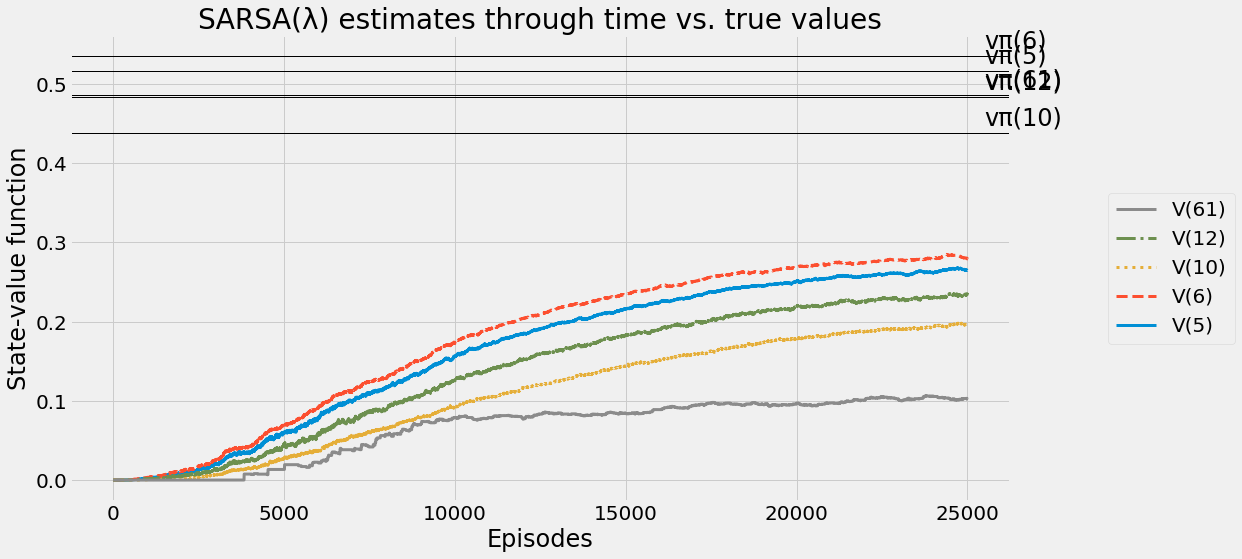

In [74]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    limit_items=5,
    limit_value=0.05,
    log=False)

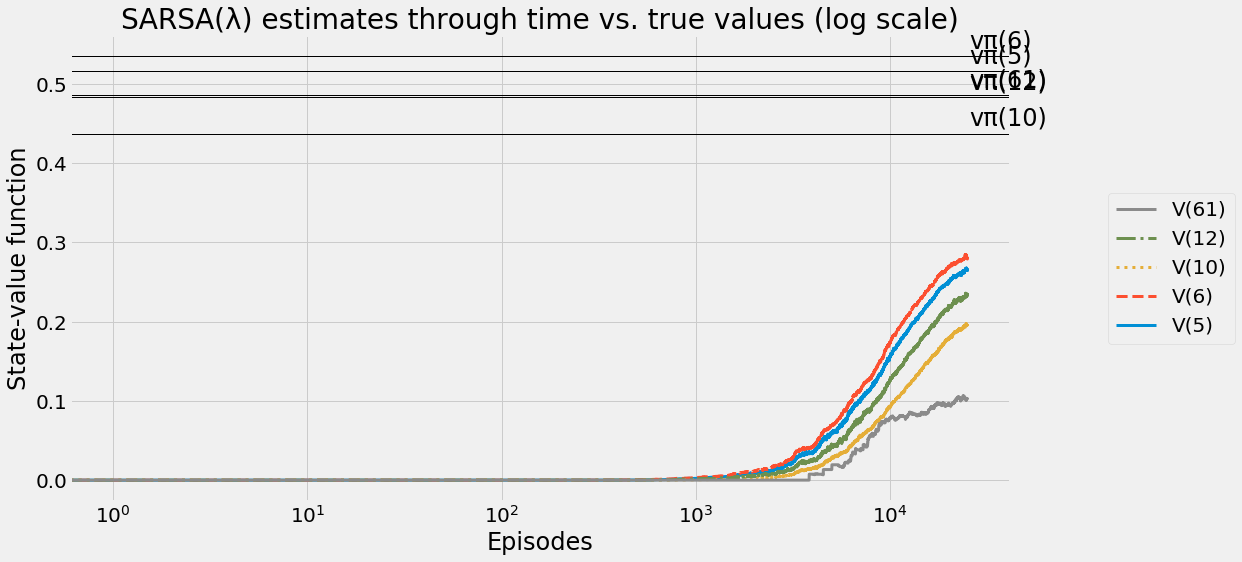

In [75]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    limit_items=5,
    limit_value=0.05,
    log=True)

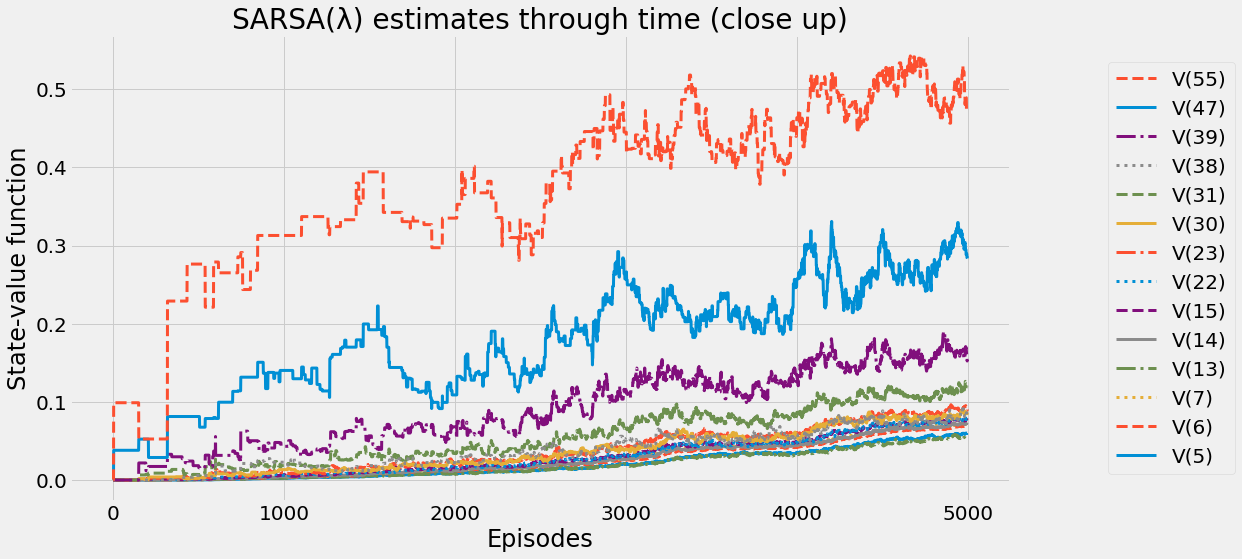

In [76]:
plot_value_function(
    'SARSA(λ) estimates through time (close up)', 
    np.max(Q_track_sl, axis=2)[:5000], 
    None,
    log=False)

## Q(λ)

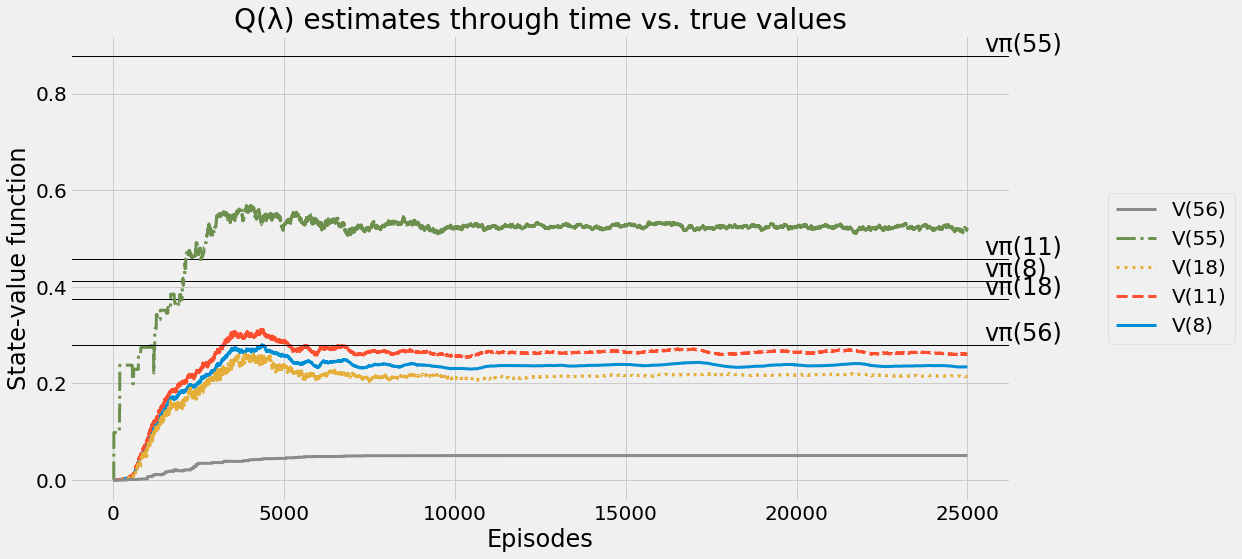

In [77]:
plot_value_function(
    'Q(λ) estimates through time vs. true values', 
    np.max(Q_track_qll, axis=2), 
    optimal_V,
    limit_items=5,
    limit_value=0.05,
    log=False)

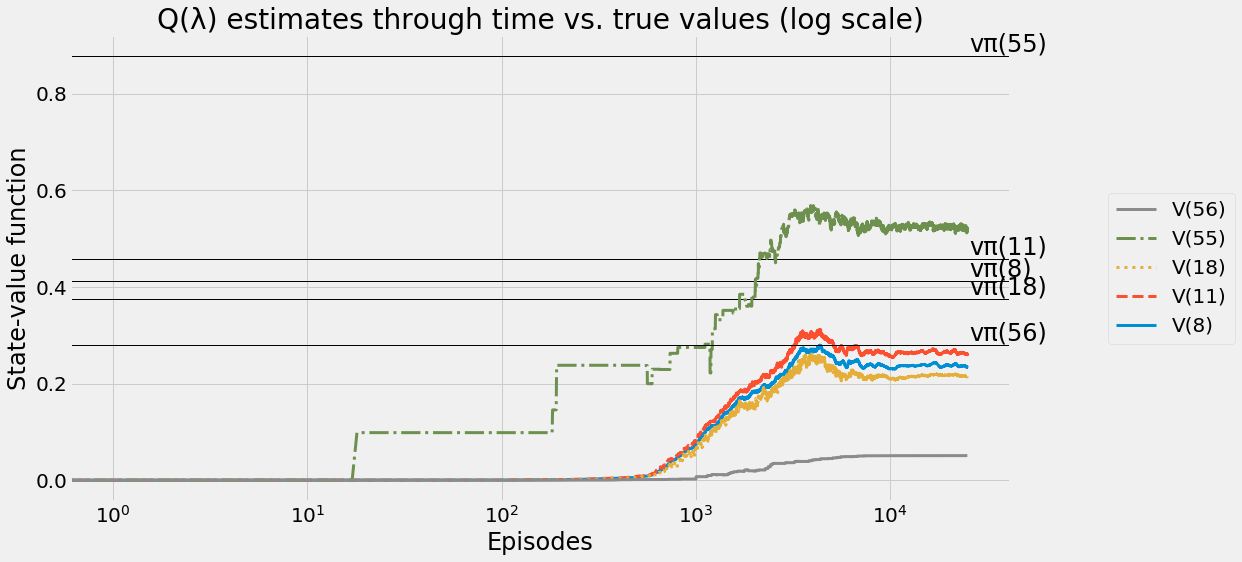

In [78]:
plot_value_function(
    'Q(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_qll, axis=2), 
    optimal_V, 
    limit_items=5,
    limit_value=0.05,
    log=True)

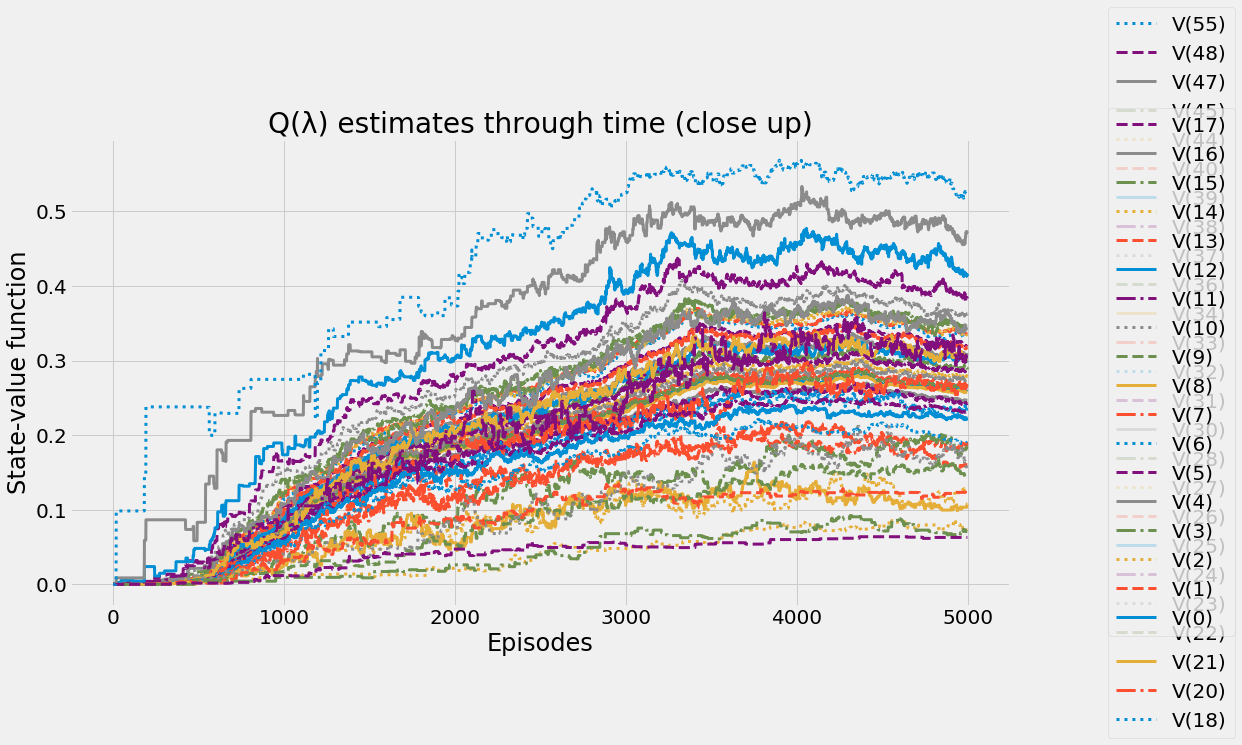

In [79]:
plot_value_function(
    'Q(λ) estimates through time (close up)', 
    np.max(Q_track_qll, axis=2)[:5000], 
    None,
    log=False)

## Dyna-Q

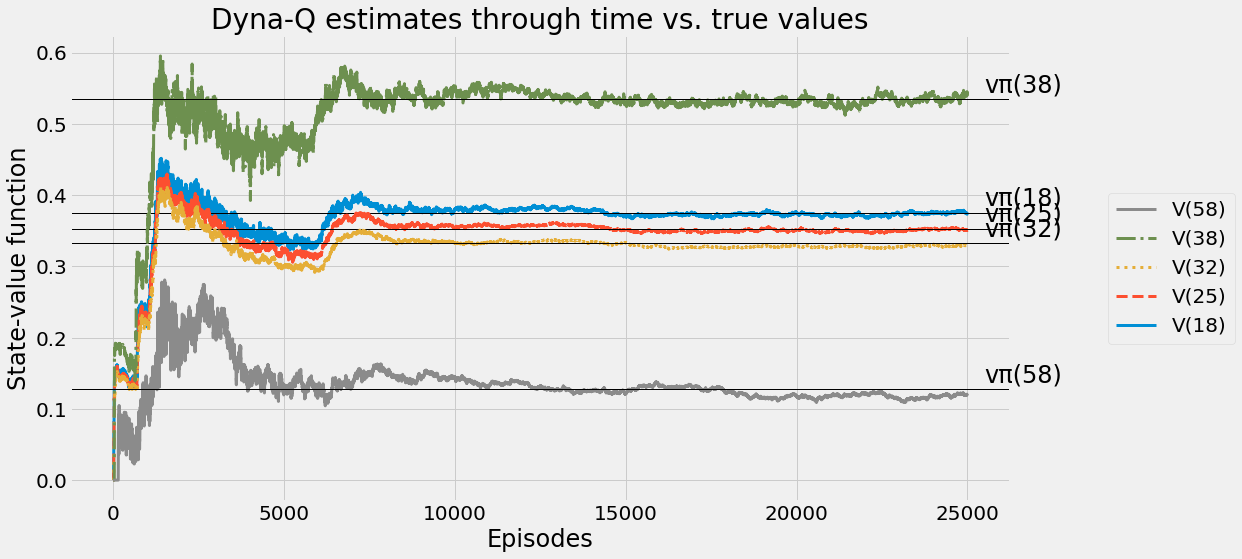

In [80]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    limit_items=5,
    limit_value=0.05,
    log=False)

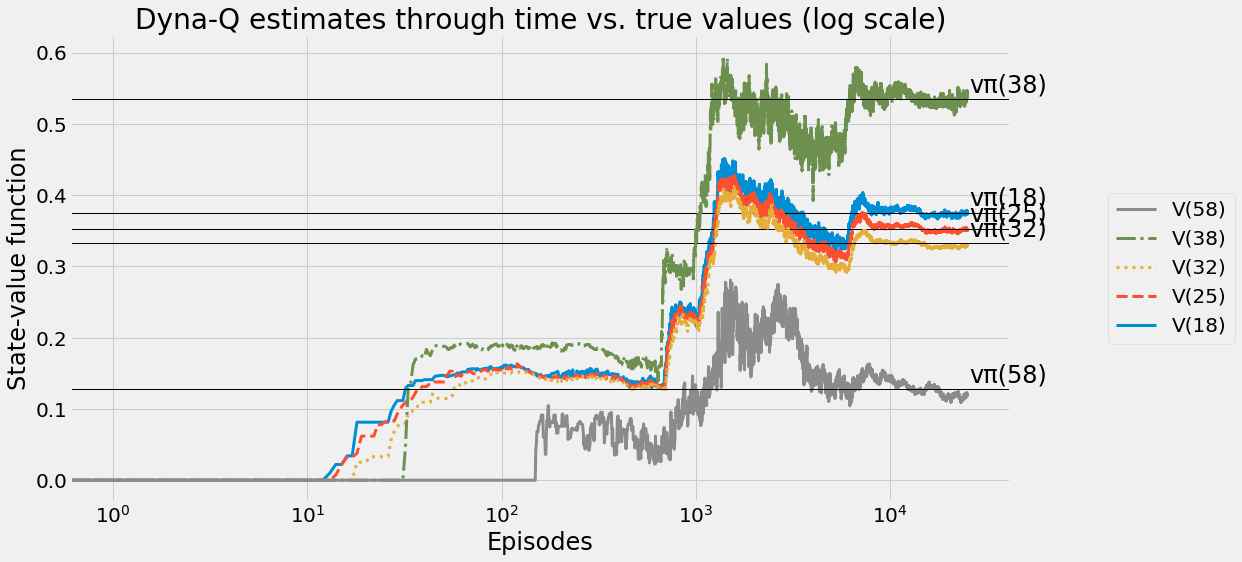

In [81]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (log scale)', 
    np.max(Q_track_dq, axis=2), 
    optimal_V,
    limit_items=5,
    limit_value=0.05,
    log=True)

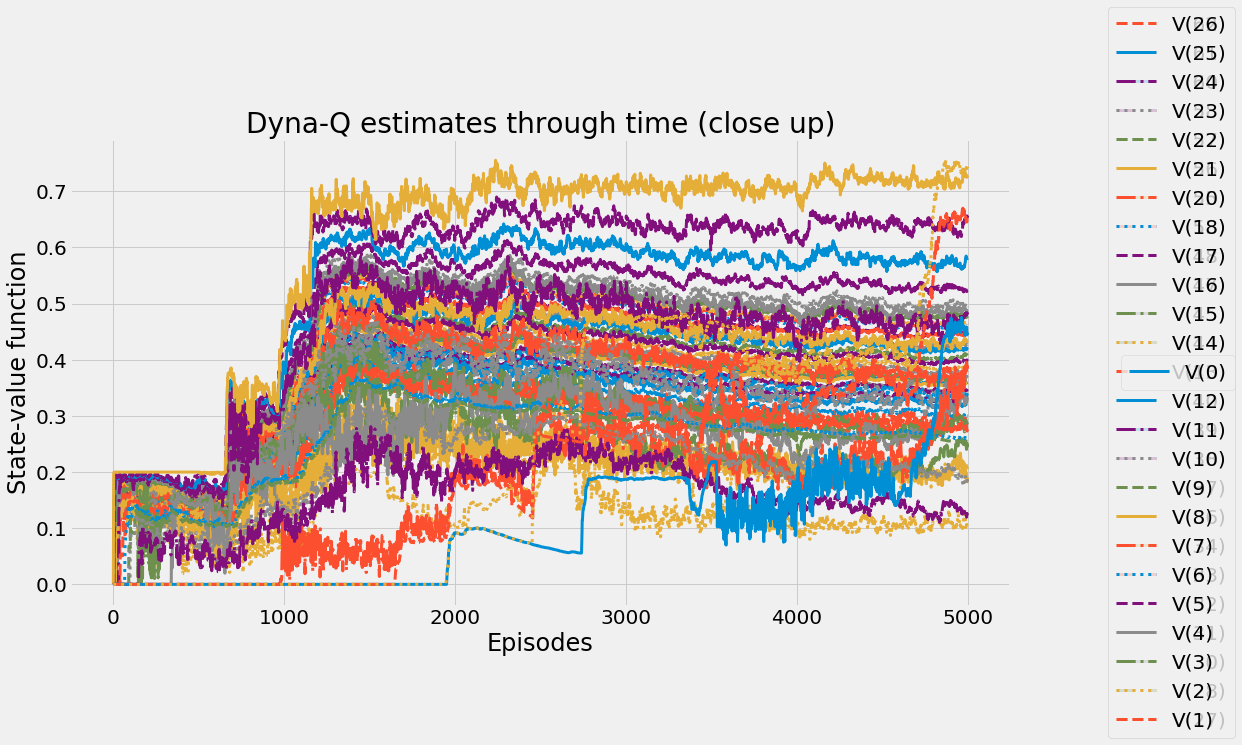

In [82]:
plot_value_function(
    'Dyna-Q estimates through time (close up)', 
    np.max(Q_track_dq, axis=2)[:5000], 
    None,
    log=False)

# Policy evolution comparison

In [83]:
sl_success_rate_ma, sl_mean_return_ma, sl_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_sl)])).T

In [84]:
qll_success_rate_ma, qll_mean_return_ma, qll_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_qll)])).T

In [85]:
dq_success_rate_ma, dq_mean_return_ma, dq_mean_regret_ma = np.apply_along_axis(
    moving_average, axis=0, arr=np.array(
        [get_policy_metrics(
            env, 
            pi=lambda s: pi[s], 
            goal_state=goal_state, 
            optimal_Q=optimal_Q) for pi in tqdm(pi_track_dq)])).T

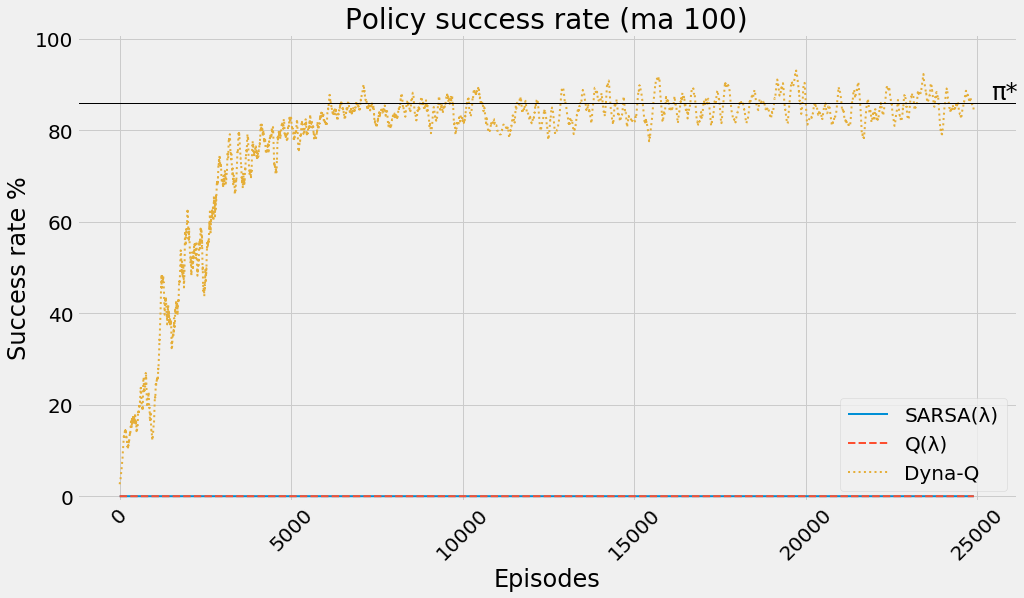

In [86]:
plt.plot(sl_success_rate_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_success_rate_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_success_rate_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=success_rate_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(sl_success_rate_ma)*1.02), success_rate_op*1.01, 'π*')

plt.title('Policy success rate (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.ylim(-1, 101)
plt.xticks(rotation=45)

plt.show()

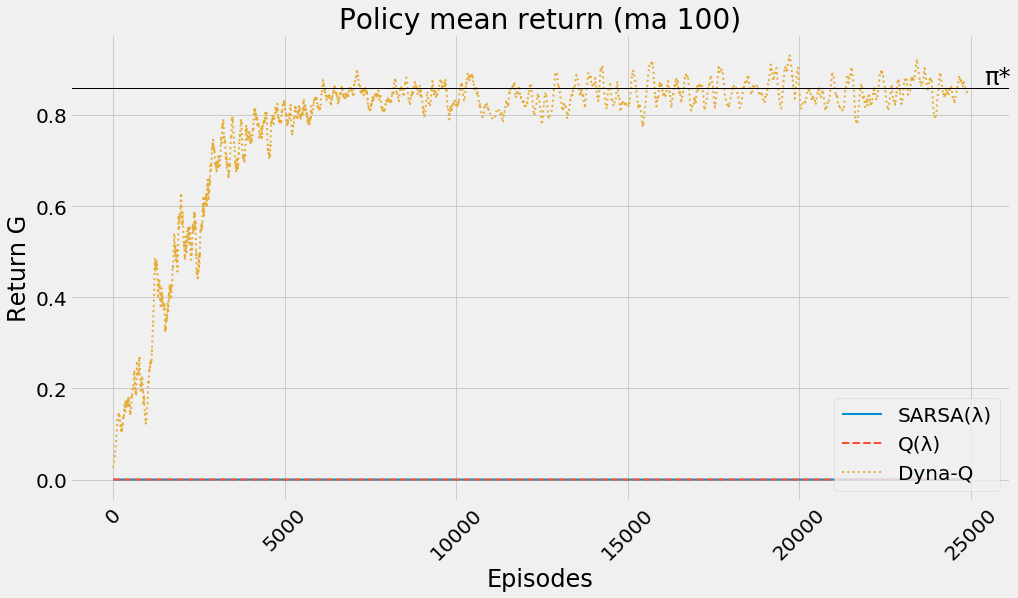

In [87]:
plt.plot(sl_mean_return_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_mean_return_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_mean_return_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=mean_return_op, color='k', linestyle='-', linewidth=1)
plt.text(int(len(sl_mean_return_ma)*1.02), mean_return_op*1.01, 'π*')

plt.title('Policy mean return (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Return G')

plt.xticks(rotation=45)

plt.show()

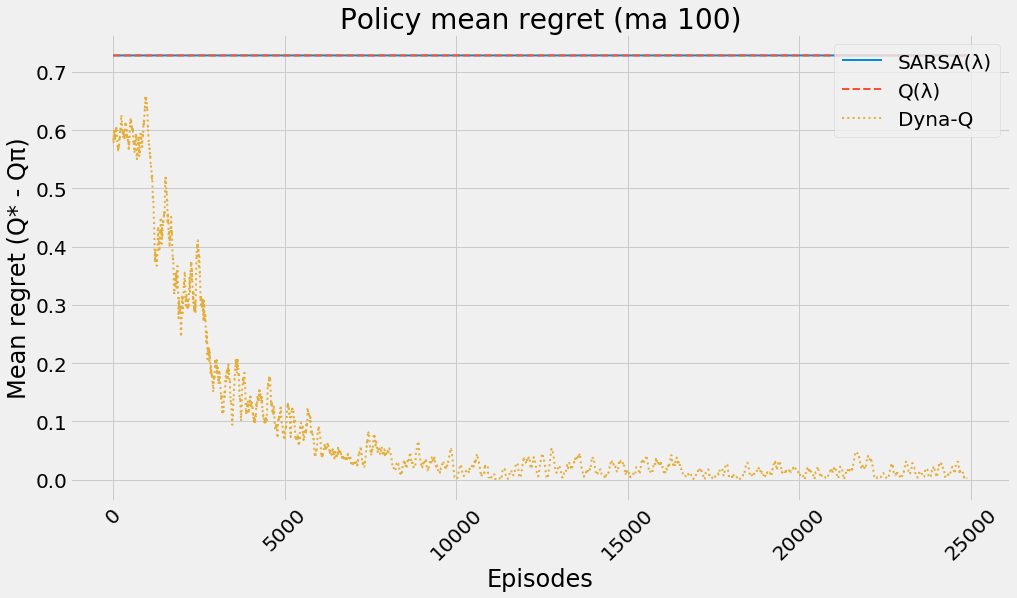

In [88]:
plt.plot(sl_mean_regret_ma, '-', linewidth=2, label='SARSA(λ)')
plt.plot(qll_mean_regret_ma, '--', linewidth=2, label='Q(λ)')
plt.plot(dq_mean_regret_ma, ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Policy mean regret (ma 100)')
plt.xlabel('Episodes')
plt.ylabel('Mean regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

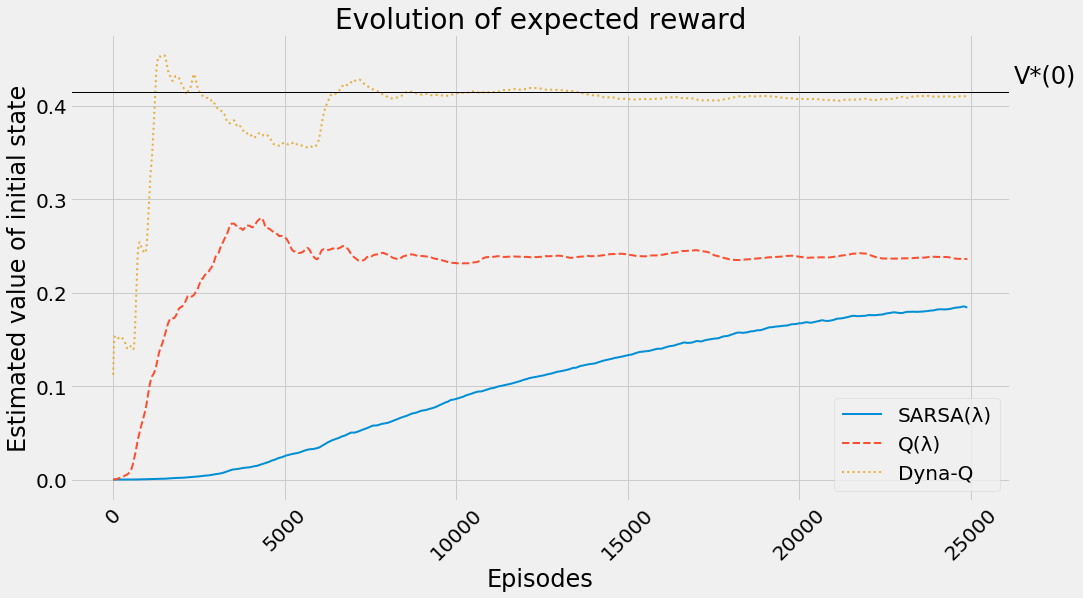

In [89]:
plt.plot(moving_average(np.max(Q_track_sl, axis=2).T[init_state]), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.max(Q_track_qll, axis=2).T[init_state]), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[init_state]), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=4, ncol=1)

plt.axhline(y=optimal_V[init_state], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_sl)*1.05), optimal_V[init_state]+.01, 'V*(0)')

plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

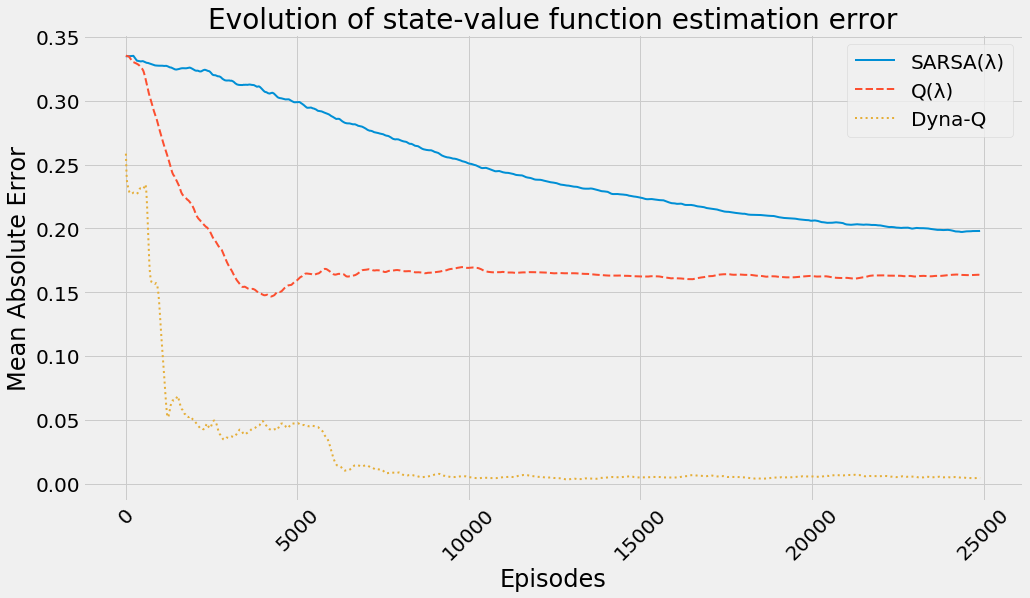

In [90]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sl, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_qll, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

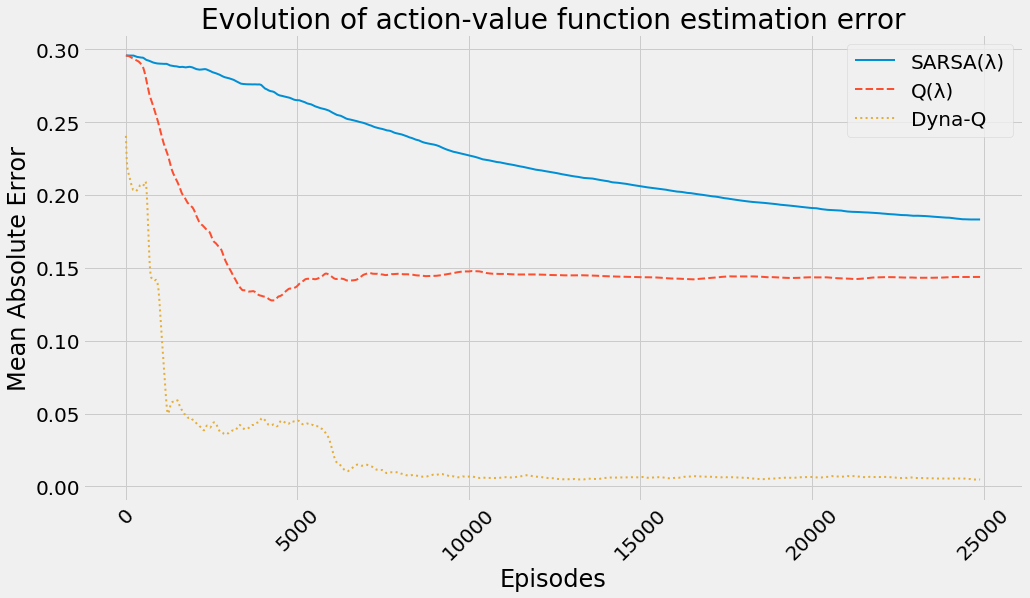

In [91]:
plt.plot(moving_average(np.mean(np.abs(Q_track_sl - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_qll - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Dyna-Q')
plt.legend(loc=1, ncol=1)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()